In [ ]:
import random
import sys
from collections import deque
from itertools import product

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import gym
from gym import Env, Wrapper
from gym.envs.registration import EnvSpec
from gym.spaces import Discrete, Box

# from overcooked_ai_py.mdp.actions import Direction
# from overcooked_ai_py.mdp.overcooked_mdp import ObjectState, SoupState, Recipe, PlayerState
# from overcooked_ai_py.visualization.state_visualizer import StateVisualizer


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## gym wrapper

In [ ]:

"""
Assigning constants to relevant information so we're not using magic numbers in the env's code
"""

# Actions
ACTION_MEANINGS = ["up", "down", "left", "right", "act"]
OFFSETS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
JOINT_ACTION_MEANINGS = list(product(ACTION_MEANINGS, repeat=2))

# Features
BASE_FEATURES_MEANING = ["a0_row", "a0_column", "a1_row", "a1_column", "a0_heading", "a1_heading", "a0_hand", "a1_hand", "pan"]
EMPTY, ONE_ONION, TWO_ONIONS, THREE_ONIONS, SOUP_READY = range(5)       # Soup pan state
NORTH, SOUTH, WEST, EAST = range(4)                                     # Agent headings (turn direction)
HOLDING_NOTHING, HOLDING_ONION, HOLDING_DISH, HOLDING_SOUP = range(4)   # Agent hand state and balconies
HIGHEST_VALUE = 0   # EMPTY soup pan and agent HOLDING_NOTHING
LOWEST_VALUE = 4    # SOUP_READY

"""
Layouts
Design your maps here!

    X = Wall
    B = Balcony
    P = Soup Pan
    S = Soup Delivery Window
    O = Onion Supply
    D = Dish Supply
      = Walking Space for Both Agents
    1 = Walking Space for Agents 1
    2 = Walking Space for Agents 2

"""

LAYOUTS = {
    "small_l": np.array([
        ["X", "X", "X", "P", "X"],
        ["O", "1", "B", "2", "X"],
        ["D", "1", "B", "2", "X"],
        ["X", "X", "X", "S", "X"],
    ]),
    "small_r": np.array([
        ["X", "X", "X", "P", "X"],
        ["O", "2", "B", "1", "X"],
        ["D", "2", "B", "1", "X"],
        ["X", "X", "X", "S", "X"],
    ]),
    "open_space": np.array([
        ["X", "X", "X", "X", "P", "X"],
        ["X", " ", " ", " ", " ", "X"],
        ["O", " ", "B", "B", " ", "X"],
        ["D", " ", "B", "B", " ", "X"],
        ["X", " ", " ", " ", " ", "X"],
        ["X", "X", "X", "X", "S", "X"],
    ]),
    "simple_kitchen": np.array([
        ["X", "X", "P", "S", "X", "X"],
        ["X", " ", " ", " ", " ", "X"],
        ["X", " ", "B", "B", " ", "X"],
        ["X", " ", " ", " ", " ", "X"],
        ["X", "X", "O", "D", "X", "X"],
    ]),
    "kitchen": np.array([
        ["X", "X", "X", "X", "P", "X", "S", "X"],
        ["X", " ", " ", " ", " ", " ", " ", "X"],
        ["X", " ", "B", "B", "B", "B", " ", "X"],
        ["X", " ", " ", " ", " ", " ", " ", "X"],
        ["X", "X", "X", "O", "X", "D", "X", "X"],
    ])
    # ,
    # "lab": np.array([
    #     ["X", "X", "X", "X", "P", "X", "S", "X"],
    #     ["X", " ", " ", " ", " ", " ", " ", "X"],
    #     ["X", " ", " ", " ", " ", " ", " ", "X"],
    #     ["X", " ", " ", " ", " ", " ", " ", "X"],
    #     ["X", " ", " ", " ", " ", " ", " ", "X"],
    #     ["X", " ", " ", " ", " ", " ", " ", "X"],
    #     ["X", " ", " ", " ", " ", " ", " ", "X"],
    #     ["X", " ", " ", " ", " ", " ", " ", "X"],
    #     ["X", " ", " ", " ", " ", " ", " ", "X"],
    #     ["X", "X", "X", "O", "X", "D", "X", "X"]
    # ])
    # ,
    # "cover_page": np.array([
    #     ["X", "X", "P", "P", "P", "X", "X", "X", "X", "X", "X", "X", "X", "P", "P", "P", "X", "X"],
    #     ["X", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "X"],
    #     ["X", " ", "B", "B", "B", " ", " ", "B", "B", "B", " ", " ", "B", "B", "B", " ", " ", "O"],
    #     ["O", " ", "B", " ", " ", "B", " ", "B", " ", " ", "B", " ", "B", " ", " ", "B", " ", "O"],
    #     ["O", " ", "B", " ", " ", "B", " ", "B", "B", "B", " ", " ", "B", "B", "B", " ", " ", "D"],
    #     ["D", " ", "B", " ", " ", "B", " ", "B", " ", " ", " ", " ", "B", " ", " ", " ", " ", "X"],
    #     ["X", " ", "B", "B", "B", " ", " ", "B", " ", " ", " ", " ", "B", " ", " ", " ", " ", "X"],
    #     ["X", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "X"],
    #     ["X", "X", "X", "X", "X", "X", "X", "S", "S", "S", "S", "X", "X", "X", "X", "X", "X", "X"],
    # ])  # This layout should not be used, since it has more than one pan.

}


class Overcooked(Env):

    def __init__(self, layout="small", max_timesteps=float("inf"), rewards=(-0.1, 2, 5, 20)):

        # Attributes
        self.layout: np.ndarray = np.copy(LAYOUTS[layout]) if isinstance(layout, str) else np.copy(layout)
        self.num_rows, self.num_columns = self.layout.shape
        self.action_meanings = ACTION_MEANINGS
        self.joint_action_meanings = JOINT_ACTION_MEANINGS
        self.num_actions = len(self.action_meanings)
        self.num_joint_actions = len(self.joint_action_meanings)
        self.valid_start_cells_a0 = self._valid_start_cells(self.layout, 0)
        self.valid_start_cells_a1 = self._valid_start_cells(self.layout, 1)
        self.layout[self.layout == '1'] = ' '   # For rendering and transitions
        self.layout[self.layout == '2'] = ' '   # For rendering and transitions
        self.balconies = self._balconies(self.layout)
        self.num_balconies = len(self.balconies)
        self.pan = self._pan_location(self.layout)
        self.features_meaning = BASE_FEATURES_MEANING + [f"balcony_{b}" for b in range(self.num_balconies)]
        self.max_timesteps = max_timesteps  # added

        # Rewards
        if len(rewards) != 4:
            raise ValueError("The rewards must be a tuple with exactly 4 numeric values.")
        self.move_reward, self.onion_added_reward, self.pickup_soup_reward, self.deliver_soup_reward = rewards

        # OpenAI Gym
        # self.spec = EnvSpec(id=id)
        self.num_features = len(self.features_meaning)
        self.observation_space = Box(
            low=LOWEST_VALUE, high=HIGHEST_VALUE,
            shape=(len(self.features_meaning),), dtype=int)
        self.action_space = Discrete(self.num_joint_actions)
        self.reward_range = (self.move_reward, self.deliver_soup_reward)
        self.metadata = {}

        self._timestep = 0
        self.state = self._random_initial_state()
        # self.frame = self.render_state(self.state)

        rows, cols = self.layout.shape
        self.agent_positions_dict = {}
        i = 0
        for r in range(rows):
            for c in range(cols):
                if self.layout[r, c] == " " or self.layout[r, c] == 1 or self.layout[r, c] == 2:
                    self.agent_positions_dict[(r, c)] = i
                    i += 1

        self.valid_positions = len(self.agent_positions_dict)
        self.num_features = 2 * self.valid_positions + 4*4 + 5 + 4*self.num_balconies

    # Main interface

    def reset(self):
        self.state = self._random_initial_state()
        return self.state

    def step(self, joint_action: int):
        next_state, reward, terminal, info = self.transition(self.state, joint_action)
        self.state = next_state
        self._timestep += 1
        return next_state, reward, terminal, info

    def render(self):
        pass

    def transition(self, state, joint_action):

        a0, a1 = self.unpack_joint_action(joint_action)
        a0_meaning, a1_meaning = self.joint_action_meanings[joint_action]

        a0_row, a0_column, a1_row, a1_column, a0_heading, a1_heading, a0_hand, a1_hand, pan = state[:9]
        balcony_contents = self.balcony_contents(state)

        def interact(object_row, object_column, hand, next_pan, next_balconies, reward):

            descriptor = self.layout[object_row, object_column]

            # Nothing
            if descriptor == 'X' or descriptor == ' ':
                next_hand = hand

            # Kitchen balcony
            elif descriptor == 'B':
                balcony_cell = object_row, object_column
                balcony_index = self.balconies.index(balcony_cell)
                balcony_contents = next_balconies[balcony_index]
                able_to_pick = balcony_contents != HOLDING_NOTHING and hand == HOLDING_NOTHING
                able_to_drop = balcony_contents == HOLDING_NOTHING and hand != HOLDING_NOTHING
                if able_to_pick:
                    next_hand = balcony_contents
                    next_balconies[balcony_index] = HOLDING_NOTHING
                elif able_to_drop:
                    next_balconies[balcony_index] = hand
                    next_hand = HOLDING_NOTHING
                else:
                    next_hand = hand

            # Onion Supply
            elif descriptor == 'O':
                able_to_pick_onion = hand == HOLDING_NOTHING
                able_to_drop_onion = hand == HOLDING_ONION
                if able_to_pick_onion: next_hand = HOLDING_ONION
                elif able_to_drop_onion: next_hand = HOLDING_NOTHING
                else: next_hand = hand

            # Dish Supply
            elif descriptor == 'D':
                able_to_pick_dish = hand == HOLDING_NOTHING
                able_to_drop_dish = hand == HOLDING_DISH
                if able_to_pick_dish: next_hand = HOLDING_DISH
                elif able_to_drop_dish: next_hand = HOLDING_NOTHING
                else: next_hand = hand

            # Soup pan
            elif descriptor == 'P':

                able_to_add_onion = hand == HOLDING_ONION and next_pan in [EMPTY, ONE_ONION, TWO_ONIONS]
                able_to_pickup_soup = hand == HOLDING_DISH and next_pan == SOUP_READY

                if able_to_add_onion:
                    next_pan = next_pan + 1
                    next_hand = HOLDING_NOTHING
                    reward = self.onion_added_reward
                elif able_to_pickup_soup:
                    next_pan = EMPTY
                    next_hand = HOLDING_SOUP
                    reward = self.pickup_soup_reward
                else:
                    next_hand = hand

            # Soup delivery window
            elif descriptor == "S":
                able_to_deliver_soup = hand == HOLDING_SOUP
                if able_to_deliver_soup:
                    next_hand = HOLDING_NOTHING
                    reward = self.deliver_soup_reward
                else:
                    next_hand = hand
            else:
                raise ValueError("Should be unreachable")

            return next_hand, next_pan, next_balconies, reward

        def cell_facing_agent(row, column, direction):

            dr, dc = OFFSETS[direction]
            object_row = row + dr
            object_column = column + dc

            if object_row < 0: object_row = 0
            if object_row > self.num_rows: object_row = self.num_rows - 1

            if object_column < 0: object_column = 0
            if object_column > self.num_columns: object_column = self.num_columns - 1

            return object_row, object_column

        def try_move_agent(row, column, direction, teammate_row, teammate_column):

            dr, dc = OFFSETS[direction]
            next_row = row + dr
            next_column = column + dc

            if next_row < 0: next_row = 0
            if next_row > self.num_rows: next_row = self.num_rows - 1

            if next_column < 0: next_column = 0
            if next_column > self.num_columns: next_column = self.num_columns - 1

            # TODO fix out of bounds error when indexing numpy array with values larger than rows/columns and lower than zero
            # in_bounds = next_row < self.layout.shape[0] and next_column < self.layout.shape[1]
            walking_area = self.layout[next_row, next_column] == ' '
            blocked_by_teammate = teammate_row == next_row and teammate_column == next_column

            if walking_area and not blocked_by_teammate:
                return next_row, next_column
            else:
                return row, column

        def step_agent(row, column, heading, hand, action, action_meaning, teammate_row, teammate_column, next_pan, next_balconies, reward):
            moving = action_meaning != "act"
            if moving and heading != action:
                # Turn
                next_heading = action
                next_row, next_column = row, column
                next_hand = hand
            elif moving and heading == action:
                # Move
                next_row, next_column = try_move_agent(row, column, action, teammate_row, teammate_column)
                next_heading = action
                next_hand = hand
            else:
                # Act
                next_row, next_column = row, column
                next_heading = heading
                object_row, object_column = cell_facing_agent(row, column, heading)
                next_hand, next_pan, next_balconies, reward = interact(object_row, object_column, hand, next_pan, next_balconies, reward)

            return next_row, next_column, next_heading, next_hand, next_pan, next_balconies, reward

        next_pan, next_balconies = pan, balcony_contents
        reward = self.move_reward

        next_a0_row, next_a0_column, next_a0_heading, next_a0_hand, next_pan, next_balconies, reward0 = step_agent(a0_row, a0_column, a0_heading, a0_hand, a0, a0_meaning, a1_row, a1_column, next_pan, next_balconies, reward)
        next_a1_row, next_a1_column, next_a1_heading, next_a1_hand, next_pan, next_balconies, reward1 = step_agent(a1_row, a1_column, a1_heading, a1_hand, a1, a1_meaning, next_a0_row, next_a0_column, next_pan, next_balconies, reward)

        cooking = pan == THREE_ONIONS
        if cooking: next_pan = SOUP_READY

        terminal = self._timestep >= self.max_timesteps -1
        info = {}
        next_state = np.array([next_a0_row, next_a0_column, next_a1_row, next_a1_column, next_a0_heading, next_a1_heading, next_a0_hand, next_a1_hand, next_pan] + list(next_balconies))

        return next_state, max(reward0, reward1), terminal, info

    def _random_initial_state(self):
        self._timestep = 0
        a0_cell = random.choice(self.valid_start_cells_a0)
        a1_cell = a0_cell
        while a0_cell == a1_cell:
            a1_cell = random.choice(self.valid_start_cells_a1)
        a0_row, a0_column = a0_cell
        a1_row, a1_column = a1_cell
        a0_heading, a1_heading = random.choice([NORTH, SOUTH, WEST, EAST]), random.choice([NORTH, SOUTH, WEST, EAST])
        a0_hand, a1_hand = HOLDING_NOTHING, HOLDING_NOTHING
        pan = EMPTY
        balconies = [EMPTY for _ in range(self.num_balconies)]
        state = np.array([a0_row, a0_column, a1_row, a1_column, a0_heading, a1_heading, a0_hand, a1_hand, pan]
                         + balconies)
        return state

    def random_state(self):
        self._timestep = 0
        a0_cell = random.choice(self.valid_start_cells_a0)
        a1_cell = a0_cell
        while a0_cell == a1_cell:
            a1_cell = random.choice(self.valid_start_cells_a1)
        a0_row, a0_column = a0_cell
        a1_row, a1_column = a1_cell
        a0_heading, a1_heading = random.choice([NORTH, SOUTH, WEST, EAST]), random.choice([NORTH, SOUTH, WEST, EAST])
        a0_hand = random.choice([HOLDING_NOTHING, HOLDING_ONION, HOLDING_DISH, HOLDING_SOUP])
        a1_hand = random.choice([HOLDING_NOTHING, HOLDING_ONION, HOLDING_DISH, HOLDING_SOUP])
        pan = random.choice([EMPTY, ONE_ONION, TWO_ONIONS, SOUP_READY])
        balconies = [random.choice([HOLDING_NOTHING, HOLDING_ONION, HOLDING_DISH, HOLDING_SOUP])
                     for _ in range(self.num_balconies)]
        state = np.array([a0_row, a0_column, a1_row, a1_column, a0_heading, a1_heading, a0_hand, a1_hand, pan]
                         + balconies)
        return state

    def unpack_joint_action(self, joint_action: int):
        a0_meaning, a1_meaning = self.joint_action_meanings[joint_action]
        a0 = self.action_meanings.index(a0_meaning)
        a1 = self.action_meanings.index(a1_meaning)
        return a0, a1

    def pack_joint_action(self, a0, a1):
        a0_meaning = self.action_meanings[a0]
        a1_meaning = self.action_meanings[a1]
        joint_action_meaning = a0_meaning, a1_meaning
        joint_action = self.joint_action_meanings.index(joint_action_meaning)
        return joint_action

    @staticmethod
    def get_cells_for(item: str, layout: np.ndarray):
        rows, columns = np.where(layout == item)
        num_cells = len(rows)
        assert len(columns) == num_cells
        cells = [(rows[i], columns[i]) for i in range(num_cells)]
        return cells

    @staticmethod
    def balcony_contents(state):
        return state[9:]

    @staticmethod
    def _valid_start_cells(layout: np.ndarray, player: int):
        walking_space = ' '
        player = str(player + 1)
        shared_cells = Overcooked.get_cells_for(walking_space, layout)
        individual_cells = Overcooked.get_cells_for(player, layout)
        return list(set(shared_cells + individual_cells))

    @staticmethod
    def _balconies(layout: np.ndarray):
        balconies = 'B'
        return Overcooked.get_cells_for(balconies, layout)

    @staticmethod
    def _pan_location(layout):
        pan = 'P'
        pans = Overcooked.get_cells_for(pan, layout)
        assert len(pans) == 1, "Layout can only contain one pan"
        return pans[0]

    def one_hot_encoding(self, state):
        a0_row, a0_column, a1_row, a1_column, a0_heading, a1_heading, a0_hand, a1_hand, pan = state[:9]
        balcony_contents = self.balcony_contents(state)

        a0_position = np.zeros(self.valid_positions)
        a0_position[self.agent_positions_dict[(a0_row, a0_column)]] = 1
        a1_position = np.zeros(self.valid_positions)
        a1_position[self.agent_positions_dict[(a1_row, a1_column)]] = 1

        heading_0 = np.zeros(4)
        heading_0[a0_heading] = 1
        heading_1 = np.zeros(4)
        heading_1[a1_heading] = 1

        hand_0 = np.zeros(4)
        hand_0[a0_hand] = 1
        hand_1 = np.zeros(4)
        hand_1[a1_hand] = 1

        pan_contents = np.zeros(5)
        pan_contents[pan] = 1

        contents = []
        for c in balcony_contents:
            content = np.zeros(4)
            content[c] = 1
            contents.append(content)

        return np.concatenate([a0_position, a1_position, heading_0, heading_1, hand_0, hand_1, pan_contents, *contents])


## heuristic agent

In [ ]:
def heuristic_action_random(state, env):
    # 40% move randomly, 60% act (stay still)
    return random.choices([0, 1, 2, 3, 4], weights=[1, 1, 1, 1, 6])[0]

## ploting function

In [ ]:

def plot_rewards(reward_list, modelname, window=50):
    reward_array = np.array(reward_list)  # shape: (num_trials, num_episodes)
    mean_rewards = reward_array.mean(axis=0)  # average over trials
    std_rewards = reward_array.std(axis=0)    # optional: std for shaded area

    episodes = np.arange(len(mean_rewards))
    rolling_avg = np.convolve(mean_rewards, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(10, 6))
    plt.plot(episodes, mean_rewards, label="Mean Episode Reward", alpha=0.6)
    plt.plot(episodes[window - 1:], rolling_avg, label=f"{window}-Episode Rolling Avg", linewidth=2)

    # Optional: add shaded standard deviation
    plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, color='gray', alpha=0.2, label="±1 Std Dev")

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f'{modelname} - Agents Performance Over Multiple Trials')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## q learning

In [ ]:
import numpy as np
from collections import defaultdict
import random
# from overcooked_env import Overcooked  # Your Overcooked class here

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(env.num_actions))

    def get_state_key(self, state):
        # Use tuple for tabular Q-learning
        return tuple(state.astype(int))

    def select_action(self, state):
        key = self.get_state_key(state)
        if random.random() < self.epsilon:
            return random.randint(0, self.env.num_actions - 1)
        else:
            return np.argmax(self.q_table[key])

    def update(self, state, action, reward, next_state):
        key = self.get_state_key(state)
        next_key = self.get_state_key(next_state)
        best_next_action = np.argmax(self.q_table[next_key])
        td_target = reward + self.gamma * self.q_table[next_key][best_next_action]
        td_error = td_target - self.q_table[key][action]
        self.q_table[key][action] += self.alpha * td_error






In [ ]:
def train_q_learning_agent(episodes=1000, layout='small_l', num_trials = 1, maxstep = 1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    env = Overcooked(layout=layout, max_timesteps= maxstep)

    trial_rewards = []
    for trial in range(num_trials):
        agent = QLearningAgent(env,alpha=alpha, gamma=gamma, epsilon=epsilon)

        episode_rewards = []
        progress_bar = tqdm(range(episodes),desc=f"Training (Trial {trial+1}/{num_trials})", file=sys.stdout)

        for episode in progress_bar:
            state = env.reset()
            total_reward = 0
            done = False

            while not done:
                # Agent 0 (learning) selects action
                a0 = agent.select_action(state)

                # Agent 1 (heuristic)
                a1 = heuristic_action_random(state, env)

                joint_action = env.pack_joint_action(a0, a1)
                next_state, reward, done, _ = env.step(joint_action)
                # print(reward)

                agent.update(state, a0, reward, next_state)
                state = next_state
                total_reward += reward

            episode_rewards.append(total_reward)
            avg_reward = np.mean(episode_rewards[-10:])
            progress_bar.set_postfix({"Avg Reward": f"{avg_reward:.2f}"})
        trial_rewards.append(episode_rewards)


    return agent, np.array(trial_rewards)

Training (Trial 1/1): 100%|██████████| 1000/1000 [00:15<00:00, 62.96it/s, Avg Reward=-37.27]


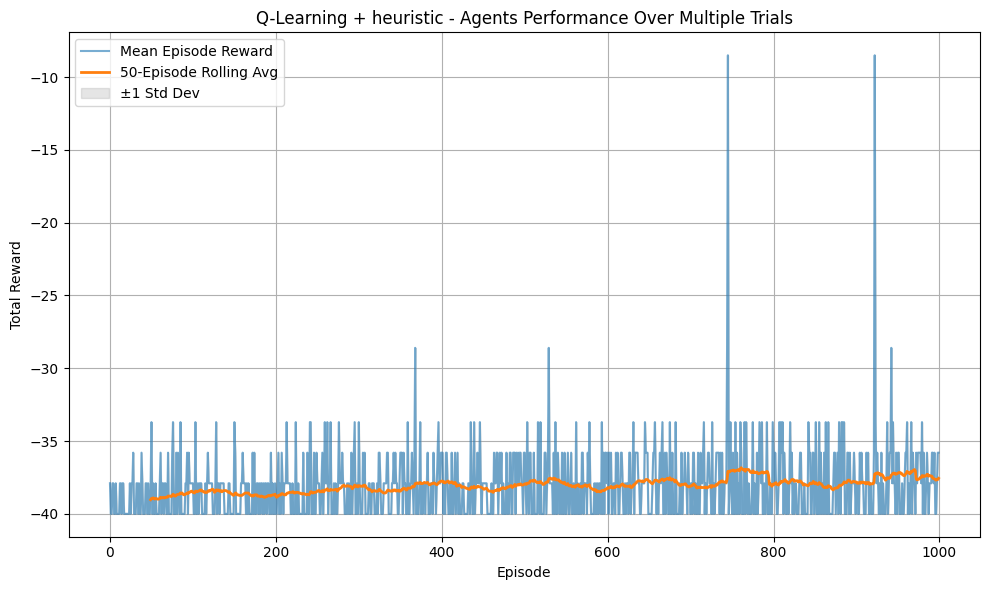

In [ ]:
trained_agent, rewards = train_q_learning_agent(episodes=1000, maxstep=400, layout='small_l', alpha=0.1, gamma=0.99, epsilon=0.1)
plot_rewards(rewards, modelname='Q-Learning + heuristic')

Training (Trial 1/1): 100%|██████████| 1000/1000 [00:15<00:00, 65.81it/s, Avg Reward=-38.32]


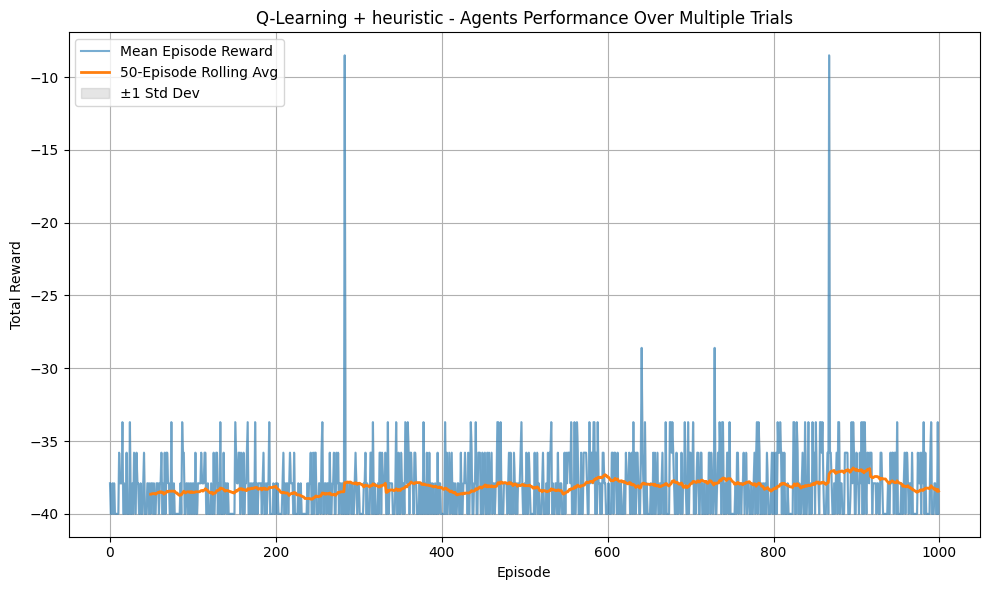

In [ ]:
trained_agent, rewards = train_q_learning_agent(episodes=1000, maxstep=400, layout='small_l', alpha=0.1, gamma=0.99, epsilon=0.2)
plot_rewards(rewards, modelname='Q-Learning + heuristic')

Training (Trial 1/1): 100%|██████████| 1000/1000 [00:14<00:00, 67.23it/s, Avg Reward=-37.90]


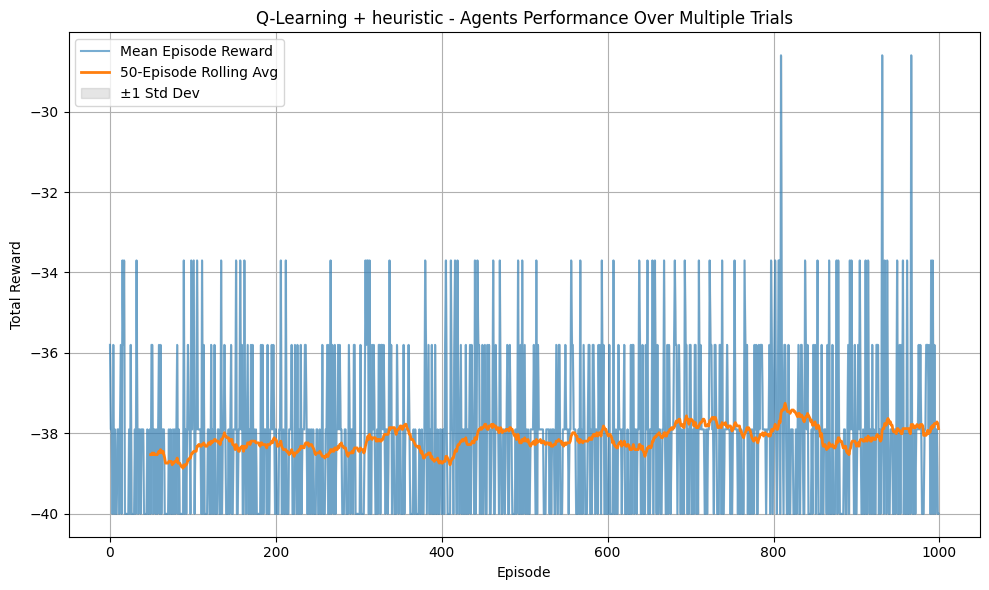

In [ ]:
trained_agent, rewards = train_q_learning_agent(episodes=1000, maxstep=400, layout='small_l', alpha=0.1, gamma=0.99, epsilon=0.5)
plot_rewards(rewards, modelname='Q-Learning + heuristic')

Training (Trial 1/1): 100%|██████████| 1000/1000 [00:15<00:00, 64.71it/s, Avg Reward=-37.69]


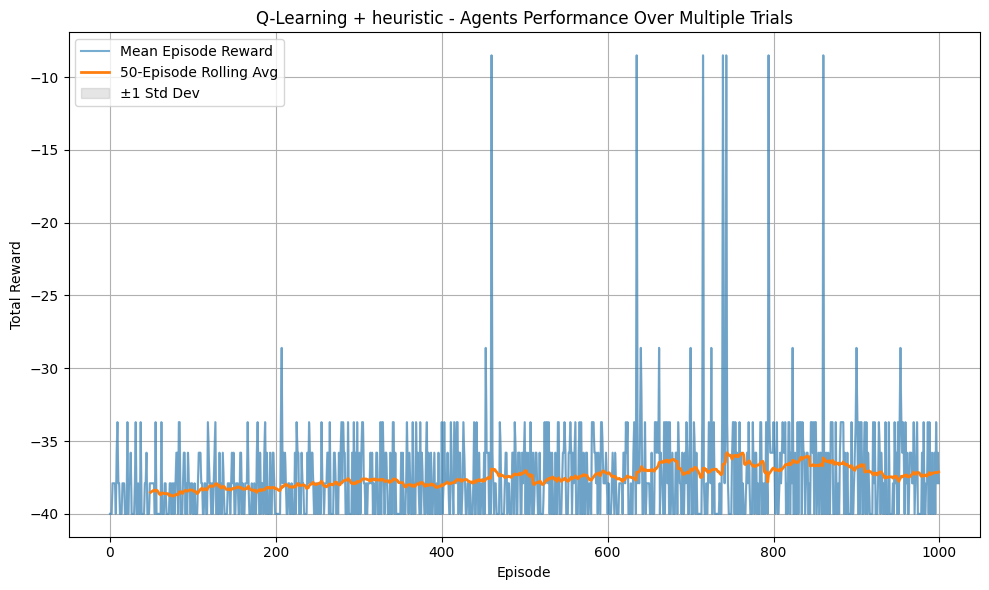

In [ ]:
trained_agent, rewards = train_q_learning_agent(episodes=1000, maxstep=400, layout='small_l', alpha=0.2, gamma=0.99, epsilon=0.1)
plot_rewards(rewards, modelname='Q-Learning + heuristic')

Training (Trial 1/1): 100%|██████████| 1000/1000 [00:15<00:00, 64.17it/s, Avg Reward=-33.70]


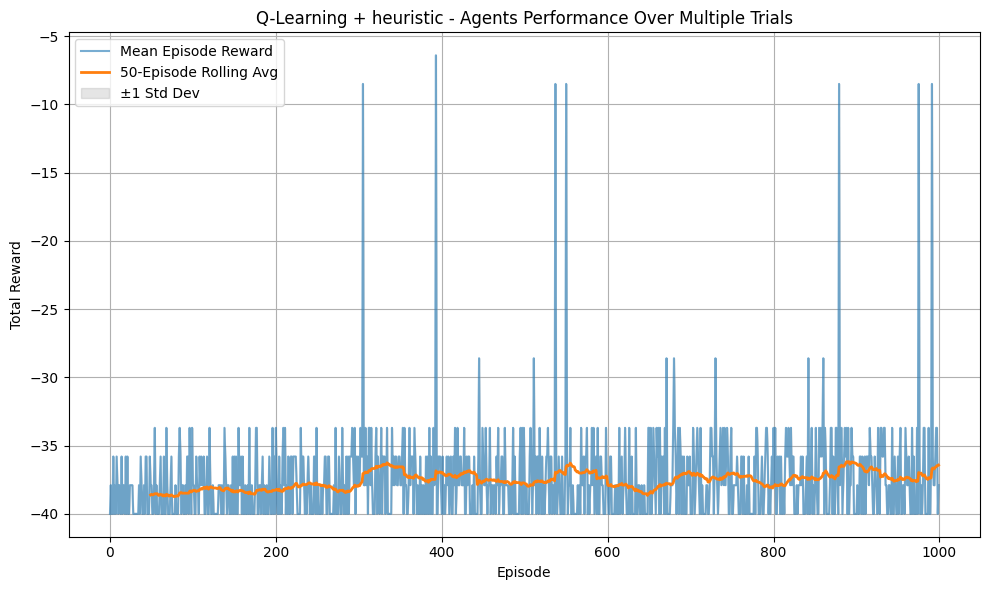

In [ ]:
trained_agent, rewards = train_q_learning_agent(episodes=1000, maxstep=400, layout='small_l', alpha=0.2, gamma=0.99, epsilon=0.2)
plot_rewards(rewards, modelname='Q-Learning + heuristic')

Training (Trial 1/1): 100%|██████████| 1000/1000 [00:15<00:00, 66.58it/s, Avg Reward=-38.95]


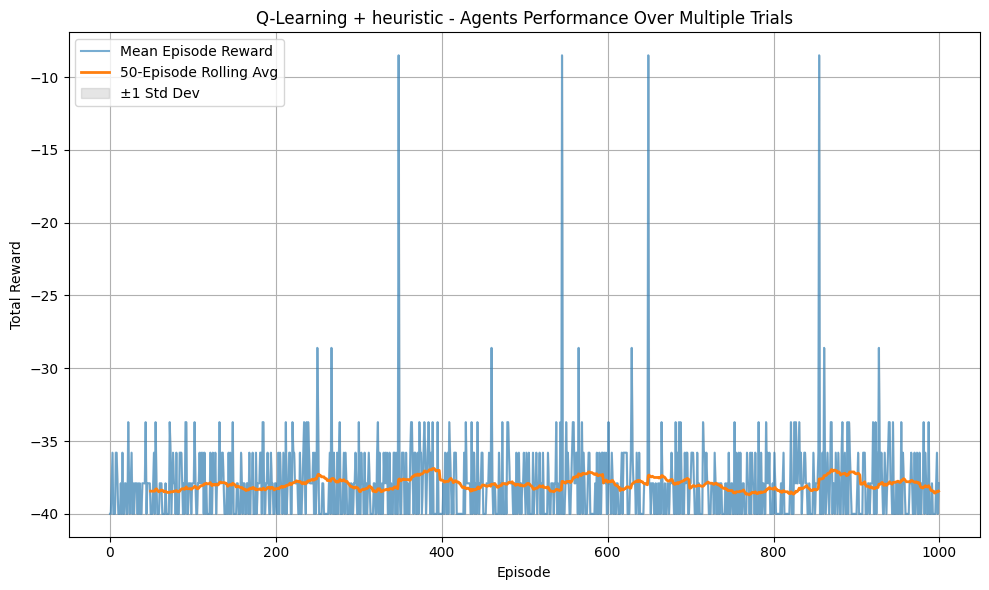

In [ ]:
trained_agent, rewards = train_q_learning_agent(episodes=1000, maxstep=400, layout='small_l', alpha=0.2, gamma=0.99, epsilon=0.5)
plot_rewards(rewards, modelname='Q-Learning + heuristic')

Training (Trial 1/1): 100%|██████████| 1000/1000 [00:15<00:00, 65.16it/s, Avg Reward=-38.53]


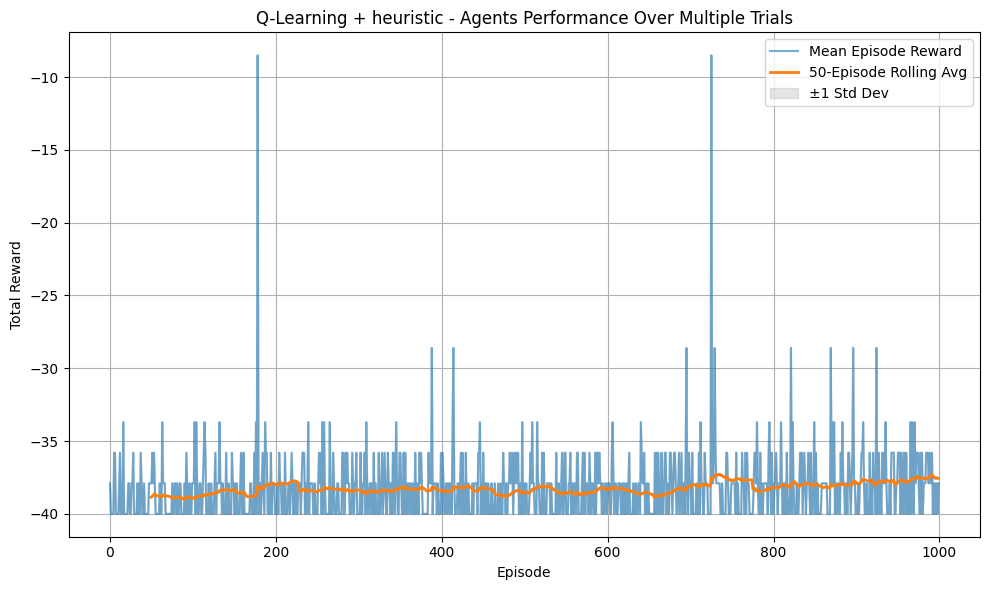

In [ ]:
trained_agent, rewards = train_q_learning_agent(episodes=1000, maxstep=400, layout='small_l', alpha=0.05, gamma=0.99, epsilon=0.1)
plot_rewards(rewards, modelname='Q-Learning + heuristic')

Training (Trial 1/1): 100%|██████████| 1000/1000 [00:15<00:00, 65.84it/s, Avg Reward=-38.32]


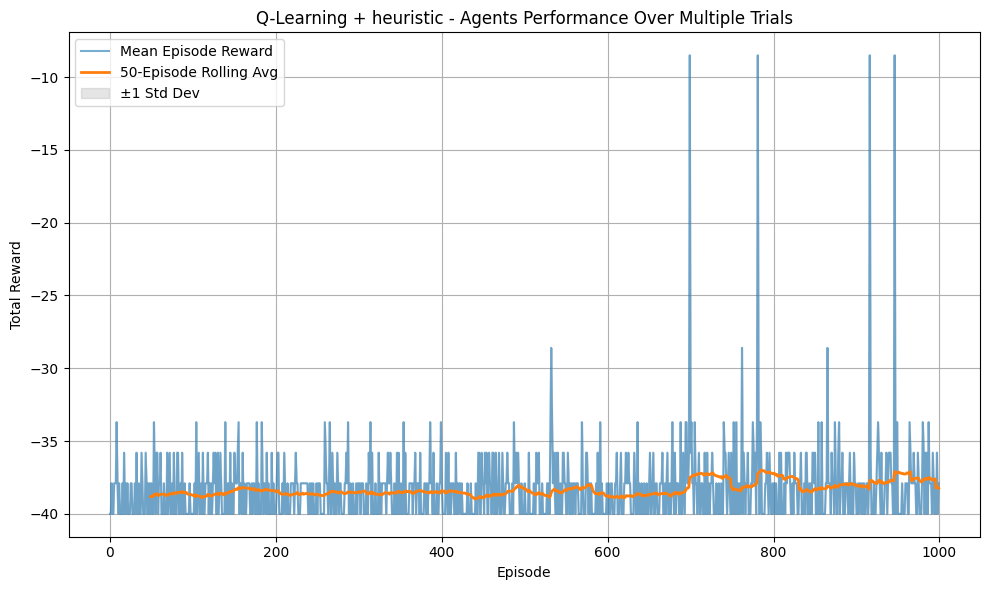

In [ ]:
trained_agent, rewards = train_q_learning_agent(episodes=1000, maxstep=400, layout='small_l', alpha=0.05, gamma=0.99, epsilon=0.2)
plot_rewards(rewards, modelname='Q-Learning + heuristic')

Training (Trial 1/1): 100%|██████████| 1000/1000 [00:14<00:00, 68.57it/s, Avg Reward=-38.53]


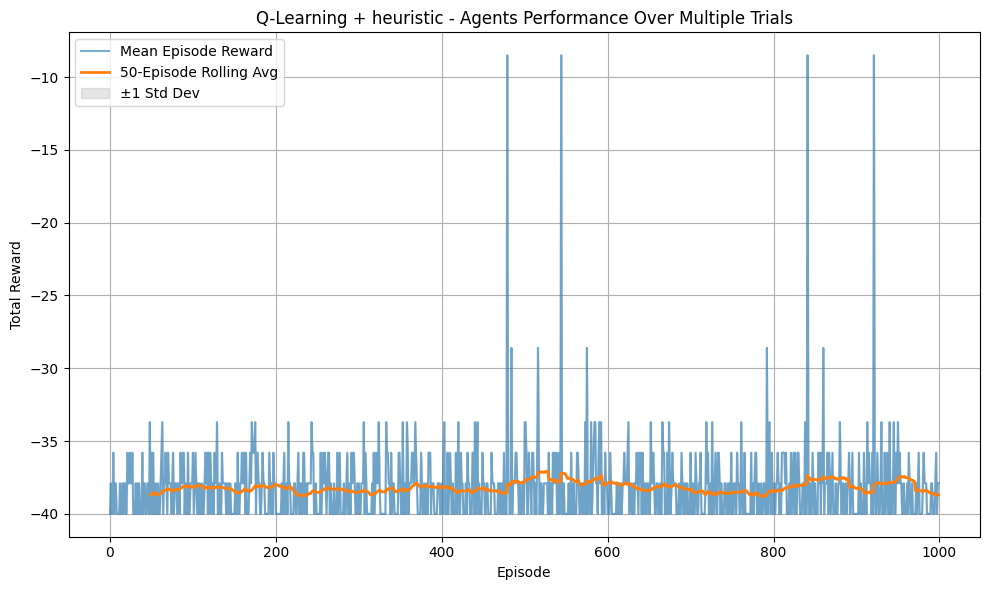

In [ ]:
trained_agent, rewards = train_q_learning_agent(episodes=1000, maxstep=400, layout='small_l', alpha=0.05, gamma=0.99, epsilon=0.5)
plot_rewards(rewards, modelname='Q-Learning + heuristic')

Training (Trial 1/1): 100%|██████████| 5000/5000 [01:17<00:00, 64.13it/s, Avg Reward=-37.90]


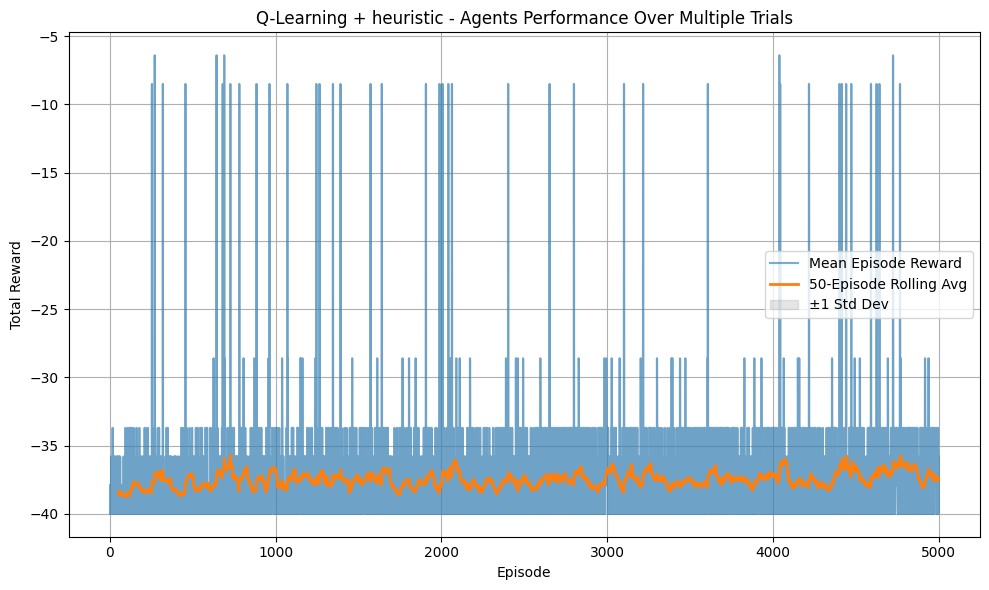

In [ ]:
trained_agent, rewards = train_q_learning_agent(episodes=5000, maxstep=400, layout='small_l', alpha=0.1, gamma=0.99, epsilon=0.1)
plot_rewards(rewards, modelname='Q-Learning + heuristic')

## DQN

In [ ]:


# --- Q-Network ---
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.array, zip(*batch))

    def __len__(self):
        return len(self.buffer)

In [ ]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")


Using device: cuda


In [ ]:
def train_dqn(episodes=1000, layout='small_l', num_trials=1, maxstep=400, gamma = 0.99,
        epsilon = 1.0,
        epsilon_decay = 0.995,
        min_epsilon = 0.1,
        batch_size = 128,
        update_target_every = 20,
              lr = 1e-3):
    trial_rewards = []

    for trial in range(num_trials):
        env = Overcooked(layout=layout, max_timesteps=maxstep)
        input_dim = env.one_hot_encoding(env.reset()).shape[0]
        output_dim = env.num_actions

        q_net = DQN(input_dim, output_dim).to(device)
        target_net = DQN(input_dim, output_dim).to(device)
        target_net.load_state_dict(q_net.state_dict())
        target_net.eval()

        optimizer = optim.Adam(q_net.parameters(), lr=lr)
        buffer = ReplayBuffer(capacity=100000)

        rewards_per_episode = []
        progress_bar = tqdm(range(episodes), desc=f"DQN Training (Trial {trial+1}/{num_trials})", file=sys.stdout)

        for ep in progress_bar:
            state = env.reset()
            state_encoded = env.one_hot_encoding(state)
            total_reward = 0
            done = False
            step_count = 0

            while not done:
                state_tensor = torch.FloatTensor(state_encoded).unsqueeze(0).to(device)

                if random.random() < epsilon:
                    a0 = random.randint(0, output_dim - 1)
                else:
                    with torch.no_grad():
                        q_values = q_net(state_tensor)
                        a0 = q_values.argmax().item()

                a1 = heuristic_action_random(state,env)
                joint_action = env.pack_joint_action(a0, a1)
                next_state, reward, done, _ = env.step(joint_action)
                next_state_encoded = env.one_hot_encoding(next_state)

                buffer.push(state_encoded, a0, reward, next_state_encoded, done)

                # Update state
                state = next_state
                state_encoded = next_state_encoded
                total_reward += reward
                step_count += 1

                # Less frequent optimization
                if len(buffer) >= batch_size:
                    s_batch, a_batch, r_batch, s2_batch, d_batch = buffer.sample(batch_size)

                    s_batch = torch.FloatTensor(s_batch).to(device)
                    a_batch = torch.LongTensor(a_batch).to(device)
                    r_batch = torch.FloatTensor(r_batch).to(device)
                    s2_batch = torch.FloatTensor(s2_batch).to(device)
                    d_batch = torch.FloatTensor(d_batch).to(device)

                    q_values = q_net(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze()
                    next_q_values = target_net(s2_batch).max(1)[0]
                    expected_q = r_batch + gamma * next_q_values * (1 - d_batch)

                    loss = nn.MSELoss()(q_values, expected_q.detach())

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            rewards_per_episode.append(total_reward)
            avg_reward = np.mean(rewards_per_episode[-10:])
            progress_bar.set_postfix({"Avg Reward": f"{avg_reward:.2f}"})

            # Sync target net and epsilon decay
            if ep % update_target_every == 0:
                target_net.load_state_dict(q_net.state_dict())
                epsilon = max(min_epsilon, epsilon * epsilon_decay)

        trial_rewards.append(rewards_per_episode)

    return q_net, np.array(trial_rewards)


In [ ]:

dqn_model, episode_rewards = train_dqn(episodes=1000, layout='small_l', num_trials=1, maxstep=400, gamma = 0.99,
        epsilon = 1.0,
        epsilon_decay = 0.995,
        min_epsilon = 0.1,
        batch_size = 128,
        update_target_every = 20, lr = 1e-3)

DQN Training (Trial 1/1): 100%|██████████| 1000/1000 [16:31<00:00,  1.01it/s, Avg Reward=-36.22]


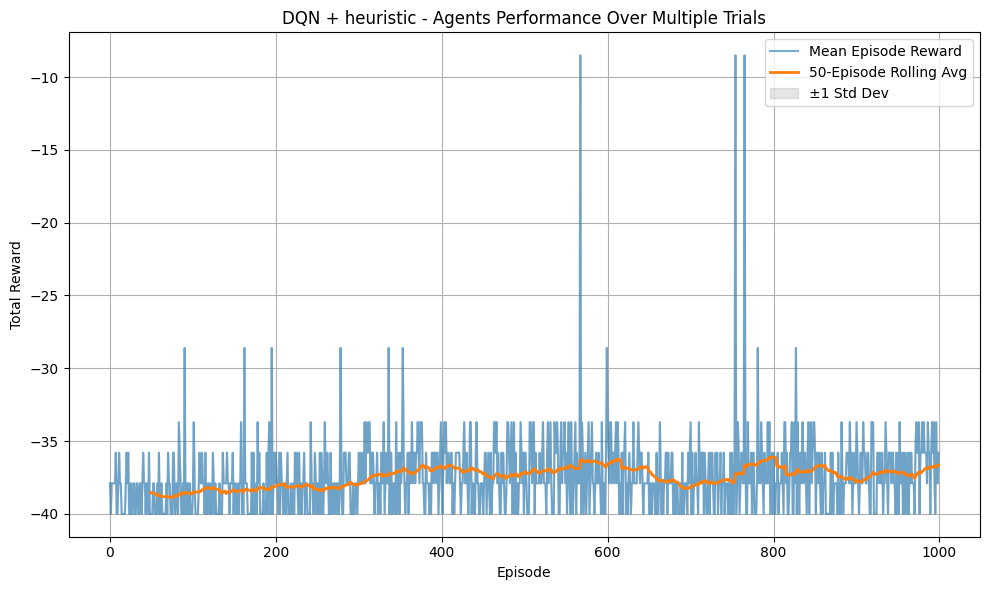

In [ ]:
plot_rewards(episode_rewards, modelname= 'DQN + heuristic')

DQN Training (Trial 1/1): 100%|██████████| 1000/1000 [17:46<00:00,  1.07s/it, Avg Reward=-36.43]


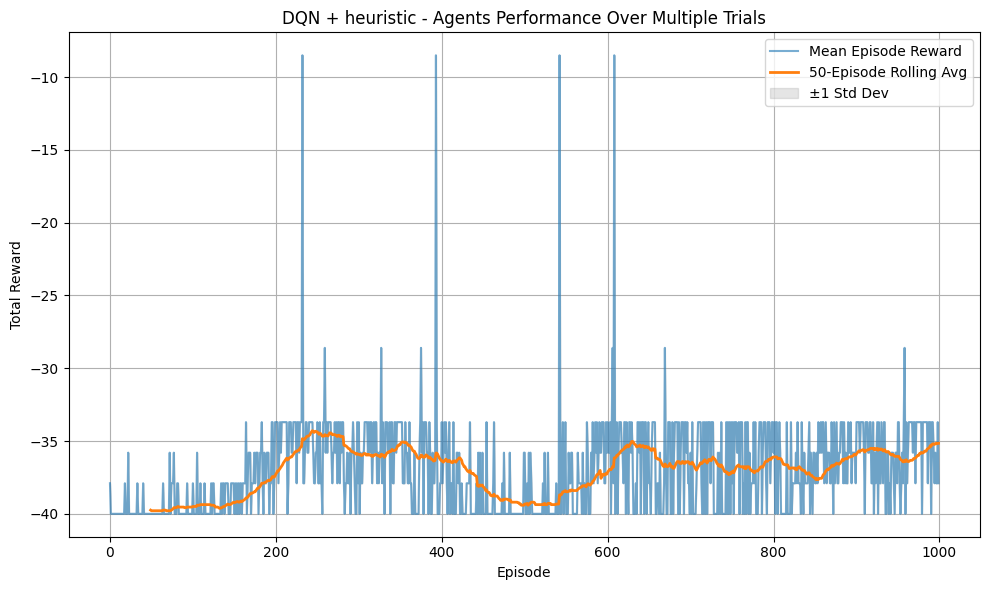

In [ ]:
dqn_model, episode_rewards = train_dqn(episodes=1000, layout='small_l', num_trials=1, maxstep=400, gamma = 0.99,
        epsilon = 0.1,
        epsilon_decay = 1,
        min_epsilon = 0.1,
        batch_size = 128,
        update_target_every = 20, lr = 1e-3)
plot_rewards(episode_rewards, modelname= 'DQN + heuristic')


DQN Training (Trial 1/1): 100%|██████████| 1000/1000 [17:50<00:00,  1.07s/it, Avg Reward=-34.33]


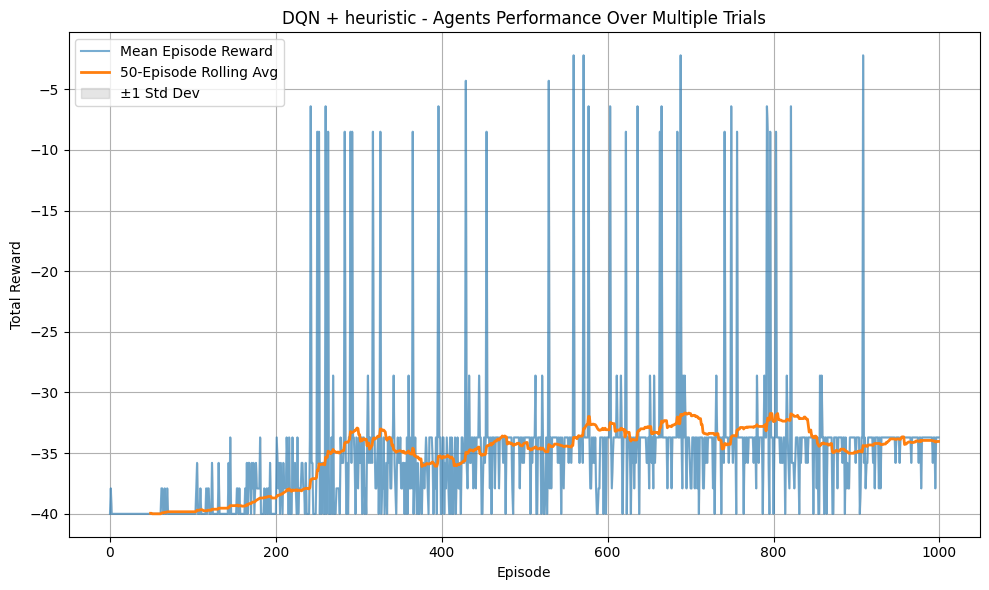

In [ ]:
dqn_model, episode_rewards = train_dqn(episodes=1000, layout='small_l', num_trials=1, maxstep=400, gamma = 0.99,
        epsilon = 0.1,
        epsilon_decay = 1,
        min_epsilon = 0.1,
        batch_size = 128,
        update_target_every = 20, lr = 1e-4)
plot_rewards(episode_rewards, modelname= 'DQN + heuristic')

DQN Training (Trial 1/1): 100%|██████████| 1000/1000 [17:28<00:00,  1.05s/it, Avg Reward=-31.18]


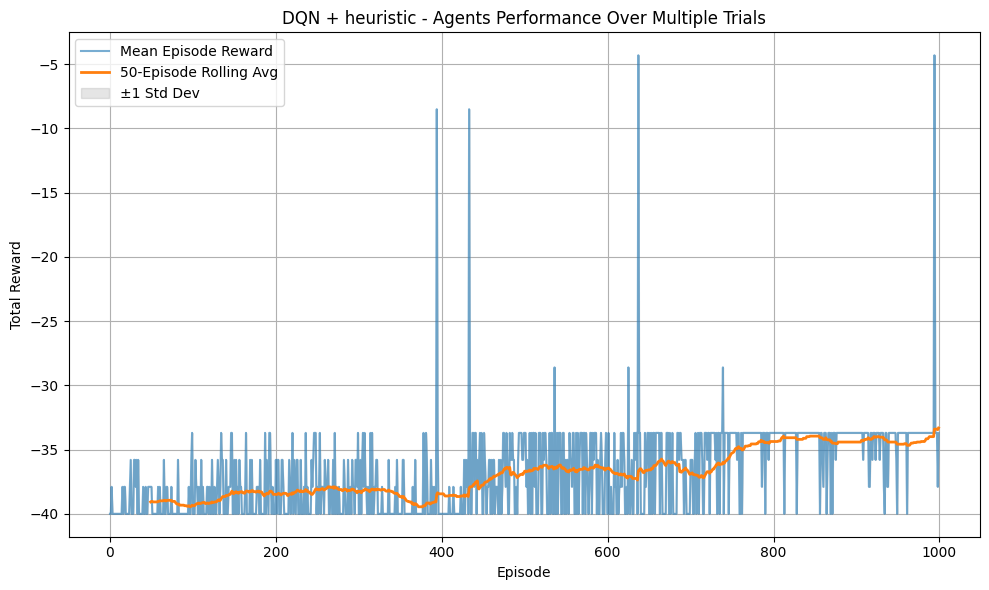

In [ ]:
dqn_model, episode_rewards = train_dqn(episodes=1000, layout='small_l', num_trials=1, maxstep=400, gamma = 0.99,
        epsilon = 0.1,
        epsilon_decay = 1,
        min_epsilon = 0.1,
        batch_size = 128,
        update_target_every = 20, lr = 1e-5)
plot_rewards(episode_rewards, modelname= 'DQN + heuristic')

DQN Training (Trial 1/1): 100%|██████████| 1000/1000 [17:40<00:00,  1.06s/it, Avg Reward=-38.95]


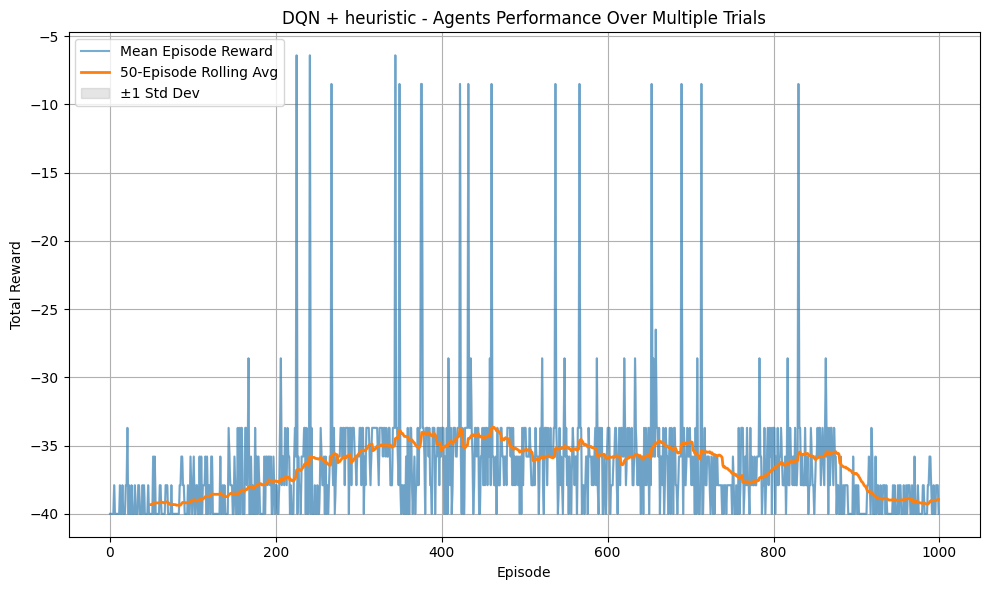

In [ ]:
dqn_model, episode_rewards = train_dqn(episodes=1000, layout='small_l', num_trials=1, maxstep=400, gamma = 0.99,
        epsilon = 0.2,
        epsilon_decay = 1,
        min_epsilon = 0.2,
        batch_size = 128,
        update_target_every = 20, lr = 1e-3)
plot_rewards(episode_rewards, modelname= 'DQN + heuristic')

DQN Training (Trial 1/1): 100%|██████████| 1000/1000 [17:39<00:00,  1.06s/it, Avg Reward=-38.53]


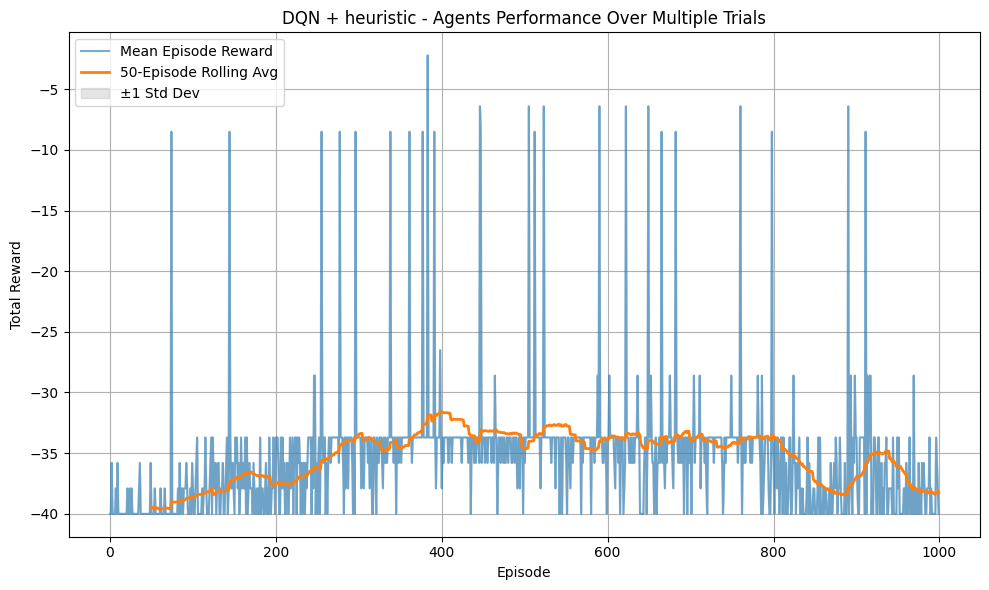

In [ ]:
dqn_model, episode_rewards = train_dqn(episodes=1000, layout='small_l', num_trials=1, maxstep=400, gamma = 0.99,
        epsilon = 0.2,
        epsilon_decay = 1,
        min_epsilon = 0.2,
        batch_size = 128,
        update_target_every = 20, lr = 1e-4)
plot_rewards(episode_rewards, modelname= 'DQN + heuristic')

DQN Training (Trial 1/1): 100%|██████████| 5000/5000 [1:46:25<00:00,  1.28s/it, Avg Reward=-33.70]


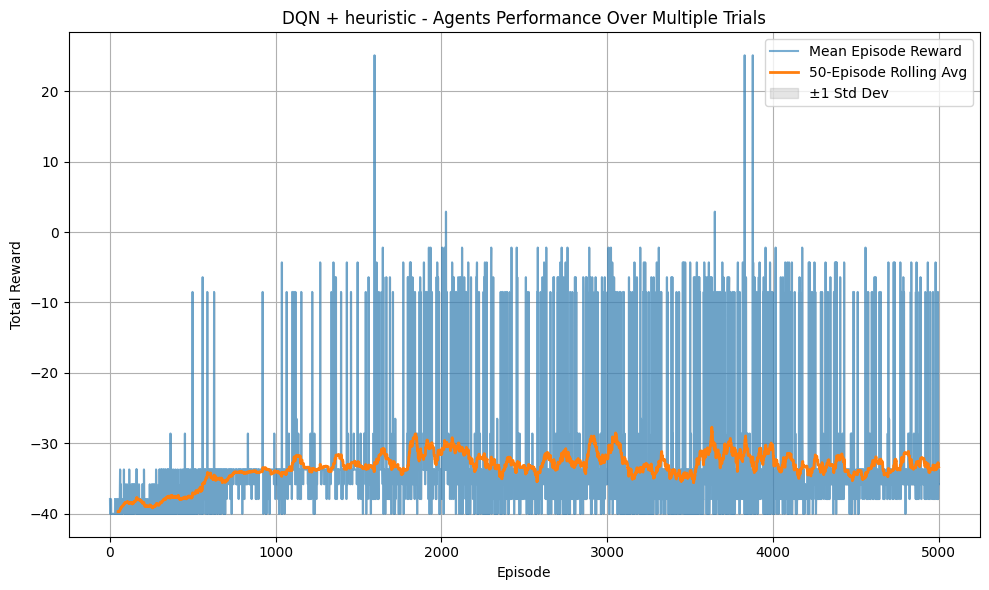

In [ ]:
dqn_model, episode_rewards = train_dqn(episodes=5000, layout='small_l', num_trials=1, maxstep=400, gamma = 0.99,
        epsilon = 0.1,
        epsilon_decay = 1,
        min_epsilon = 0.1,
        batch_size = 128,
        update_target_every = 20, lr = 1e-5)
plot_rewards(episode_rewards, modelname= 'DQN + heuristic')

## PPO

In [ ]:


# --- Actor-Critic Network ---
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # Actor: 96-64-64-6
        self.actor_net = nn.Sequential(
            nn.Linear(state_dim, 96),
            nn.ReLU(),
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
        # Critic: 48-64-64-1
        self.critic_net = nn.Sequential(
            nn.Linear(state_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        return self.actor_net(state), self.critic_net(state)

# --- Rollout Buffer ---
class RolloutBuffer:
    def __init__(self):
        self.clear()

    def clear(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []

# --- PPO Agent ---
class PPOAgent:
    def __init__(self, env, gamma=0.99, lr=1e-3, eps_clip=0.2, K_epochs=4, entropy_coef = 0.05, device="cuda"):
        self.env = env
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.device = device
        self.entropy_coef = entropy_coef

        state_dim = len(env.one_hot_encoding(env.reset()))
        action_dim = env.num_actions

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.buffer = RolloutBuffer()

    def select_action(self, state_tensor):
        """
        Expects: `state_tensor` as a float32 PyTorch tensor on the correct device (e.g., CUDA), shape: [state_dim]
        Returns:
            action:       torch.LongTensor, shape [1]
            log_prob:     torch.FloatTensor, shape [1]
            value:        torch.FloatTensor, scalar (or shape [1])
        """
        state_tensor = state_tensor.unsqueeze(0)  # Add batch dimension → [1, state_dim]

        with torch.no_grad():
            probs, value = self.policy(state_tensor)  # probs: [1, num_actions], value: [1, 1] or [1]

        dist = torch.distributions.Categorical(probs)
        action = dist.sample()                # shape: [1]
        log_prob = dist.log_prob(action)     # shape: [1]

        return action, log_prob, value.squeeze()

    def compute_returns(self, bootstrap_value, done):
        returns = []
        R = 0 if done else bootstrap_value.item()
        for reward, is_done in zip(reversed(self.buffer.rewards), reversed(self.buffer.dones)):
            R = reward + self.gamma * R * (1 - is_done)
            returns.insert(0, R)
        return torch.FloatTensor(returns).unsqueeze(1).to(self.device)

    def update(self):
        # Stack tensors instead of converting from list of tensors
        self.policy.train()
        states = torch.stack(self.buffer.states).to(self.device)
        actions = torch.LongTensor(self.buffer.actions).unsqueeze(1).to(self.device)
        old_log_probs = torch.stack(self.buffer.log_probs).unsqueeze(1).to(self.device)
        values = torch.stack(self.buffer.values).unsqueeze(1).to(self.device)

        returns = self.compute_returns(values[-1], self.buffer.dones[-1])
        # returns = returns.clamp(-10, 10)

        for _ in range(self.K_epochs):
            probs, values_pred = self.policy(states)
            dist = torch.distributions.Categorical(probs)
            new_log_probs = dist.log_prob(actions.squeeze()).unsqueeze(1)
            entropy = dist.entropy().mean()

            advantages = returns - values_pred.detach()
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
            ratio = (new_log_probs - old_log_probs).exp()

            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = nn.MSELoss()(values_pred, returns)

            loss = actor_loss + 0.5 * critic_loss - self.entropy_coef * entropy

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.buffer.clear()


In [ ]:
# --- PPO Training Loop with GPU + Trials + Progress Bar ---
def train_ppo_agent(episodes=500, maxsetep=200, layout='small_l', num_trials=1, gamma=0.99, lr=1e-3, eps_clip=0.2, K_epochs=4, entropy_coef = 0.05):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    trial_rewards = []

    for trial in range(num_trials):
        env = Overcooked(layout=layout, max_timesteps= maxsetep)
        agent = PPOAgent(env, gamma=gamma, lr=lr, eps_clip=eps_clip, K_epochs=K_epochs, entropy_coef = entropy_coef, device=device)
        episode_rewards = []

        progress_bar = tqdm(range(episodes), desc=f"PPO Training (Trial {trial+1}/{num_trials})", file=sys.stdout)

        for ep in progress_bar:
            state = env.reset()
            total_reward = 0

            for _ in range(maxsetep):
                state_vec = torch.FloatTensor(env.one_hot_encoding(state)).to(device)
                a0, log_prob, value = agent.select_action(state_vec)
                a1 = heuristic_action_random(env, state)
                joint_action = env.pack_joint_action(a0, a1)
                next_state, reward, done, _ = env.step(joint_action)

                agent.buffer.states.append(state_vec)
                agent.buffer.actions.append(a0)
                agent.buffer.log_probs.append(log_prob)
                agent.buffer.rewards.append(reward)
                agent.buffer.dones.append(float(done))
                agent.buffer.values.append(value.detach())

                state = next_state
                total_reward += reward

                if done:
                    break

            # Bootstrap final state value
            next_state_vec = env.one_hot_encoding(state)
            next_state_tensor = torch.FloatTensor(next_state_vec).unsqueeze(0).to(device)
            with torch.no_grad():
                _, next_value = agent.policy(next_state_tensor)
            agent.buffer.values.append(next_value.squeeze())

            agent.update()
            episode_rewards.append(total_reward)

            avg_reward = np.mean(episode_rewards[-10:])
            progress_bar.set_postfix({"Avg Reward": f"{avg_reward:.2f}"})

        trial_rewards.append(episode_rewards)

    return agent, np.array(trial_rewards)

Using device: cuda
PPO Training (Trial 1/1): 100%|██████████| 1000/1000 [09:15<00:00,  1.80it/s, Avg Reward=-39.16]


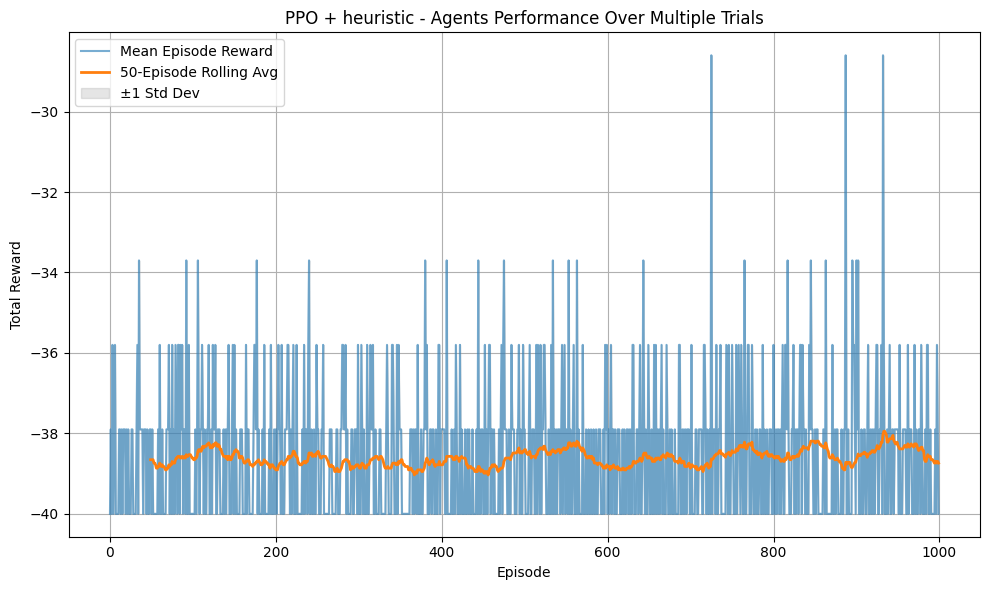

In [ ]:
ppo_agent, ppo_rewards = train_ppo_agent(episodes=1000, maxsetep=400, layout='small_l', num_trials=1, gamma=0.99, lr=1e-3, eps_clip=0.2, K_epochs=8, entropy_coef = 0.05)
plot_rewards(ppo_rewards, modelname= 'PPO + heuristic')

Using device: cuda
PPO Training (Trial 1/1): 100%|██████████| 1000/1000 [09:20<00:00,  1.78it/s, Avg Reward=-39.37]


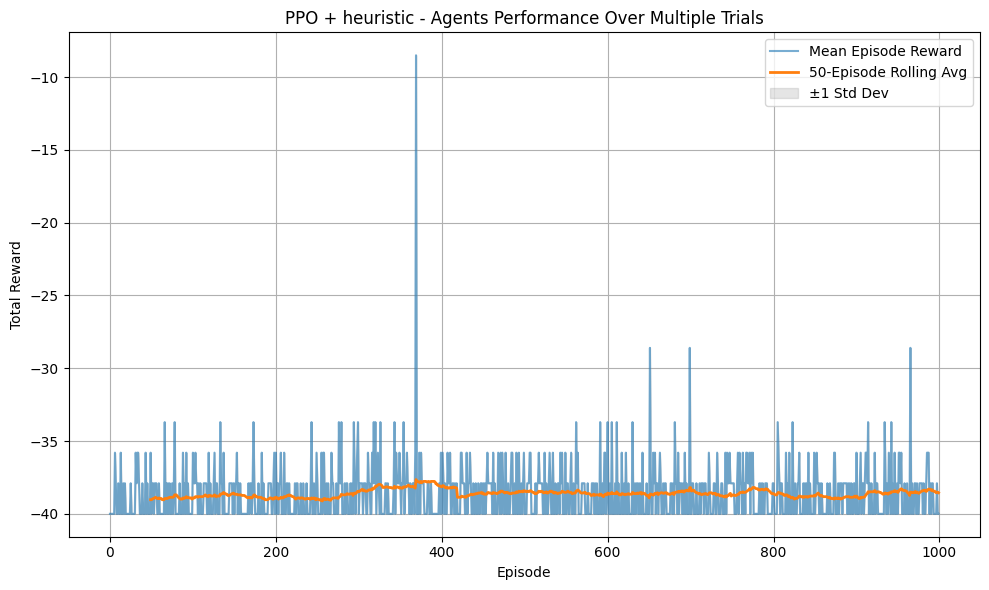

In [ ]:
ppo_agent, ppo_rewards = train_ppo_agent(episodes=1000, maxsetep=400, layout='small_l', num_trials=1, gamma=0.99, lr=1e-4, eps_clip=0.2, K_epochs=6, entropy_coef = 0.05)
plot_rewards(ppo_rewards, modelname= 'PPO + heuristic')

Using device: cuda
PPO Training (Trial 1/1): 100%|██████████| 5000/5000 [46:55<00:00,  1.78it/s, Avg Reward=-39.16]


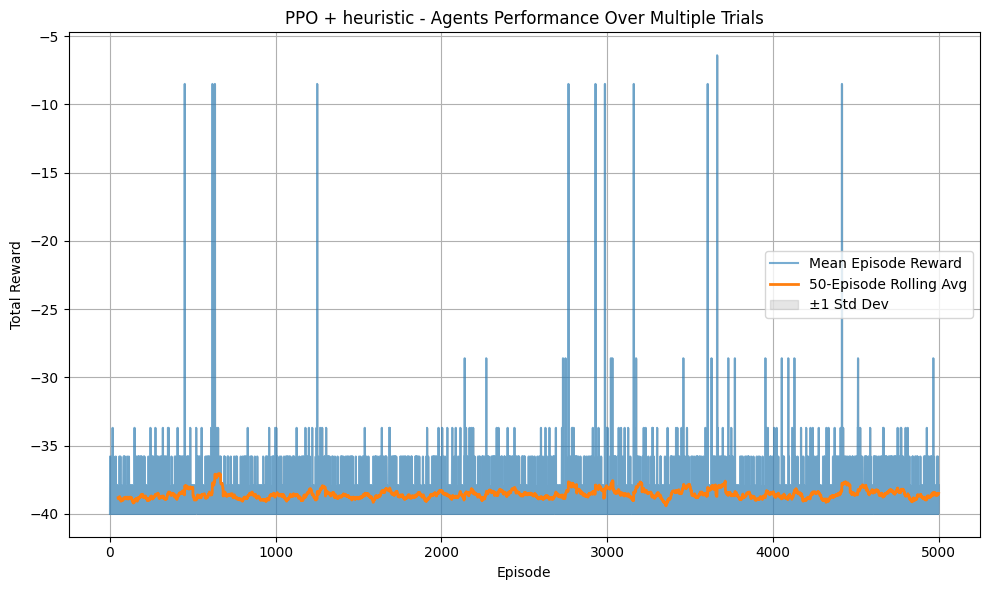

In [ ]:
ppo_agent, ppo_rewards = train_ppo_agent(episodes=5000, maxsetep=400, layout='small_l', num_trials=1, gamma=0.95, lr=1e-4, eps_clip=0.05, K_epochs=6, entropy_coef = 0.01)
plot_rewards(ppo_rewards, modelname= 'PPO + heuristic')

Using device: cuda
PPO Training (Trial 1/1): 100%|██████████| 1000/1000 [09:12<00:00,  1.81it/s, Avg Reward=-39.37]


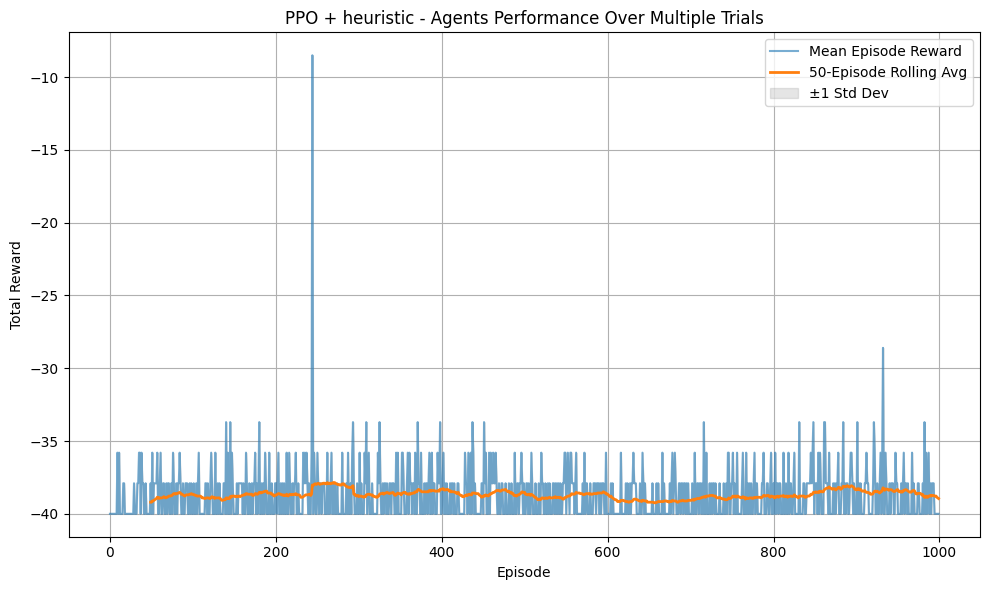

In [ ]:
ppo_agent, ppo_rewards = train_ppo_agent(episodes=1000, maxsetep=400, layout='small_l', num_trials=1, gamma=0.99, lr=1e-3, eps_clip=0.2, K_epochs=8, entropy_coef = 0.1)
plot_rewards(ppo_rewards, modelname= 'PPO + heuristic')

## TRPO

In [ ]:
# Full TRPO Agent with Conjugate Gradient Optimization
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

# --- TRPO Model ---
class TRPOActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        return self.actor(state), self.critic(state)

# --- TRPO Agent ---
class TRPOAgent:
    def __init__(self, state_dim, action_dim, device="cuda",gamma = 0.99,
        max_kl = 1e-2,
        cg_iters = 10,
        damping = 1e-2,
        ls_max_steps = 10,
        ls_backtrack_coeff = 0.8, lr = 1e-3, update_epochs = 5):

        self.device = torch.device(device)
        self.model = TRPOActorCritic(state_dim, action_dim).to(self.device)
        self.value_optimizer = torch.optim.Adam(self.model.critic.parameters(), lr=lr)
        self.gamma = gamma
        self.max_kl = max_kl
        self.cg_iters = cg_iters
        self.damping = damping
        self.ls_max_steps = ls_max_steps
        self.ls_backtrack_coeff = ls_backtrack_coeff
        self.update_epochs = update_epochs

    def select_action(self, state_tensor):
        probs, value = self.model(state_tensor.unsqueeze(0))
        dist = Categorical(probs)
        action = dist.sample()
        return action, dist.log_prob(action), value.squeeze()

    def compute_returns(self, rewards, dones, last_value):
        returns = []
        R = 0 if dones[-1] else last_value.item()
        for r, d in zip(reversed(rewards), reversed(dones)):
            R = r + self.gamma * R * (1 - d)
            returns.insert(0, R)
        return torch.tensor(returns, dtype=torch.float32).to(self.device)

    def _flatten_grads(self, grads):
        return torch.cat([g.view(-1) for g in grads])

    def _get_flat_params(self):
        return torch.cat([p.view(-1) for p in self.model.actor.parameters()])

    def _set_flat_params(self, flat_params):
        offset = 0
        for param in self.model.actor.parameters():
            size = param.numel()
            param.data.copy_(flat_params[offset:offset + size].view_as(param))
            offset += size

    def _fisher_vector_product(self, states, vector):
        vector = vector.detach()
        probs, _ = self.model(states)
        dist = Categorical(probs)
        log_probs = dist.log_prob(dist.sample())
        kl = torch.distributions.kl.kl_divergence(dist, dist).mean()

        grads = torch.autograd.grad(kl, self.model.actor.parameters(), create_graph=True)
        flat_grad_kl = self._flatten_grads(grads)

        grad_vector_product = (flat_grad_kl * vector).sum()
        hvp = torch.autograd.grad(grad_vector_product, self.model.actor.parameters())
        flat_hvp = self._flatten_grads(hvp)

        return flat_hvp + self.damping * vector

    def _conjugate_gradient(self, states, b):
        x = torch.zeros_like(b)
        r = b.clone()
        p = r.clone()
        rsold = torch.dot(r, r)
        for _ in range(self.cg_iters):
            Ap = self._fisher_vector_product(states, p)
            alpha = rsold / (torch.dot(p, Ap) + 1e-8)
            x += alpha * p
            r -= alpha * Ap
            rsnew = torch.dot(r, r)
            if torch.sqrt(rsnew) < 1e-10:
                break
            p = r + (rsnew / rsold) * p
            rsold = rsnew
        return x

    def update(self, buffer, last_value):
        states, actions, log_probs_old, rewards, values, dones = zip(*buffer)
        states = torch.stack(states)
        actions = torch.stack(actions)
        log_probs_old = torch.stack(log_probs_old).detach()
        values = torch.stack(values).detach()

        returns = self.compute_returns(rewards, dones, last_value)
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Get surrogate loss
        probs, _ = self.model(states)
        dist = Categorical(probs)
        log_probs = dist.log_prob(actions)
        ratio = torch.exp(log_probs - log_probs_old)
        surrogate = (ratio * advantages).mean()

        # Compute policy gradient
        grads = torch.autograd.grad(surrogate, self.model.actor.parameters(), retain_graph=True)
        flat_grads = self._flatten_grads(grads)

        # Compute search direction
        step_dir = self._conjugate_gradient(states, flat_grads)

        # Step size
        shs = 0.5 * (step_dir * self._fisher_vector_product(states, step_dir)).sum(0, keepdim=True)
        step_size = torch.sqrt(2 * self.max_kl / (shs + 1e-8))
        full_step = step_dir * step_size

        old_params = self._get_flat_params()

        # Line search
        for step_frac in [self.ls_backtrack_coeff ** i for i in range(self.ls_max_steps)]:
            new_params = old_params + step_frac * full_step
            self._set_flat_params(new_params)

            probs_new, _ = self.model(states)
            dist_new = Categorical(probs_new)
            log_probs_new = dist_new.log_prob(actions)
            ratio_new = torch.exp(log_probs_new - log_probs_old)
            surrogate_new = (ratio_new * advantages).mean()

            kl = torch.distributions.kl.kl_divergence(dist, dist_new).mean()
            if kl < self.max_kl and surrogate_new > surrogate:
                break
        else:
            self._set_flat_params(old_params)  # Rollback

        # Value function update
        for _ in range(self.update_epochs):
            _, value_preds = self.model(states)
            value_loss = F.mse_loss(value_preds.squeeze(), returns)
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()


In [ ]:
def train_trpo_with_heuristic(
    layout='small_l',
    episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma=0.99,
    max_kl=1e-2,
    cg_iters=10,
    damping=1e-2,
    ls_max_steps=10,
    ls_backtrack_coeff=0.8,
    lr=1e-3,
    update_epochs=5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    trial_rewards = []

    for trial in range(num_trials):
        env = Overcooked(layout=layout, max_timesteps=max_steps)
        state_dim = len(env.one_hot_encoding(env.reset()))
        action_dim = env.num_actions

        # Only training Agent 0
        agent0 = TRPOAgent(
            state_dim, action_dim, device, gamma,
            max_kl, cg_iters, damping,
            ls_max_steps, ls_backtrack_coeff,
            lr, update_epochs
        )

        episode_rewards = []
        progress_bar = tqdm(range(episodes), desc=f"TRPO+Heuristic Trial {trial+1}/{num_trials}", file=sys.stdout)

        for ep in progress_bar:
            state = env.reset()
            buffer0 = []
            total_reward = 0
            done = False

            while not done:
                state_tensor = torch.FloatTensor(env.one_hot_encoding(state)).to(device)

                a0, logp0, val0 = agent0.select_action(state_tensor)
                a1 = heuristic_action_random(state, env)

                joint_action = env.pack_joint_action(a0.item(), a1)
                next_state, reward, done, _ = env.step(joint_action)

                buffer0.append((state_tensor, a0, logp0, reward, val0, done))

                state = next_state
                total_reward += reward

            with torch.no_grad():
                final_state_tensor = torch.FloatTensor(env.one_hot_encoding(state)).to(device)
                _, val0_last = agent0.model(final_state_tensor.unsqueeze(0))

            agent0.update(buffer0, val0_last.squeeze())
            episode_rewards.append(total_reward)
            avg_reward = np.mean(episode_rewards[-10:])
            progress_bar.set_postfix({"Avg Reward": f"{avg_reward:.2f}"})

        trial_rewards.append(episode_rewards)

    return agent0, np.array(trial_rewards)

Using device: cuda
TRPO+Heuristic Trial 1/1: 100%|██████████| 1000/1000 [10:08<00:00,  1.64it/s, Avg Reward=-37.27]


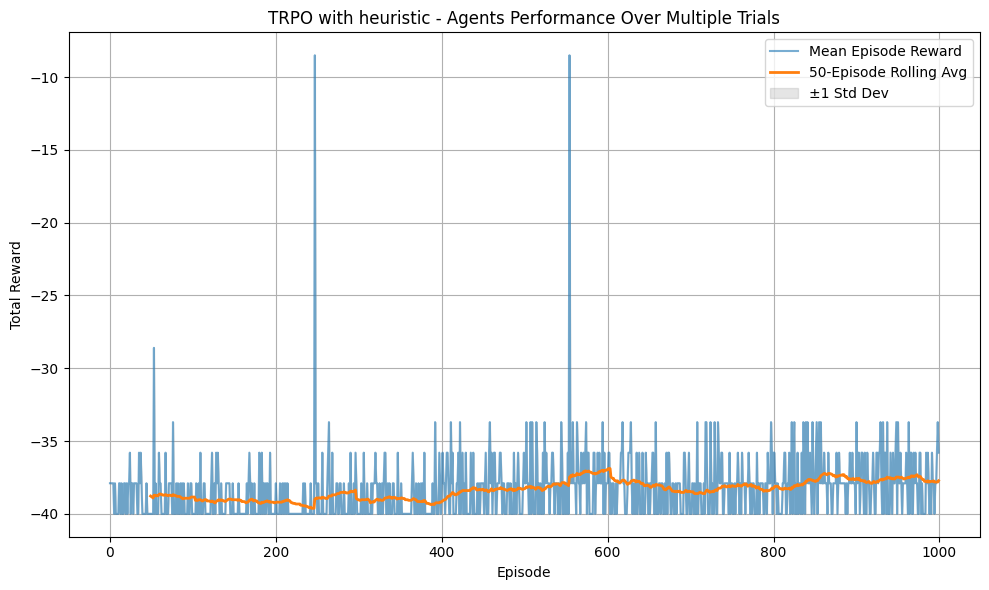

In [ ]:
agent0, rewards = train_trpo_with_heuristic(layout="small_l", episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma=0.99,
    max_kl=1e-3,
    cg_iters=10,
    damping=1e-2,
    ls_max_steps=10,
    ls_backtrack_coeff=0.8,
    lr=1e-3,
    update_epochs=5
)

plot_rewards(rewards, modelname= 'TRPO with heuristic')


Using device: cuda
TRPO+Heuristic Trial 1/1: 100%|██████████| 1000/1000 [10:15<00:00,  1.63it/s, Avg Reward=-38.74]


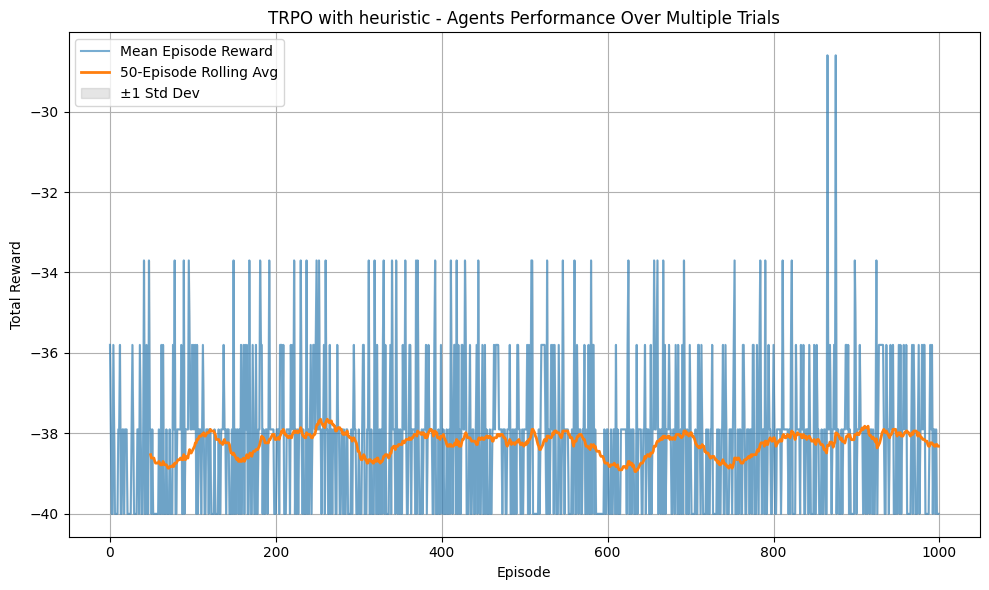

In [ ]:
agent0, rewards = train_trpo_with_heuristic(layout="small_l", episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma=0.99,
    max_kl=1e-3,
    cg_iters=10,
    damping=1e-2,
    ls_max_steps=10,
    ls_backtrack_coeff=0.8,
    lr=1e-3,
    update_epochs=10
)

plot_rewards(rewards, modelname= 'TRPO with heuristic')


Using device: cuda
TRPO+Heuristic Trial 1/1: 100%|██████████| 1000/1000 [10:15<00:00,  1.62it/s, Avg Reward=-39.37]


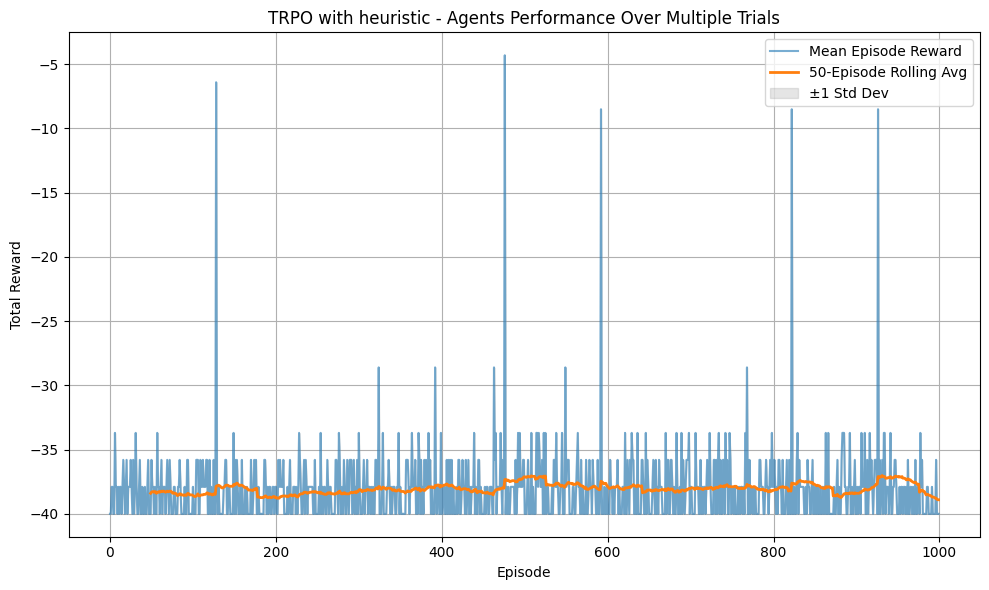

In [ ]:
agent0, rewards = train_trpo_with_heuristic(layout="small_l", episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma=0.999,
    max_kl=1e-3,
    cg_iters=10,
    damping=1e-2,
    ls_max_steps=10,
    ls_backtrack_coeff=0.8,
    lr=1e-3,
    update_epochs=10
)

plot_rewards(rewards, modelname= 'TRPO with heuristic')


Using device: cuda
TRPO+Heuristic Trial 1/1: 100%|██████████| 1000/1000 [10:18<00:00,  1.62it/s, Avg Reward=-40.00]


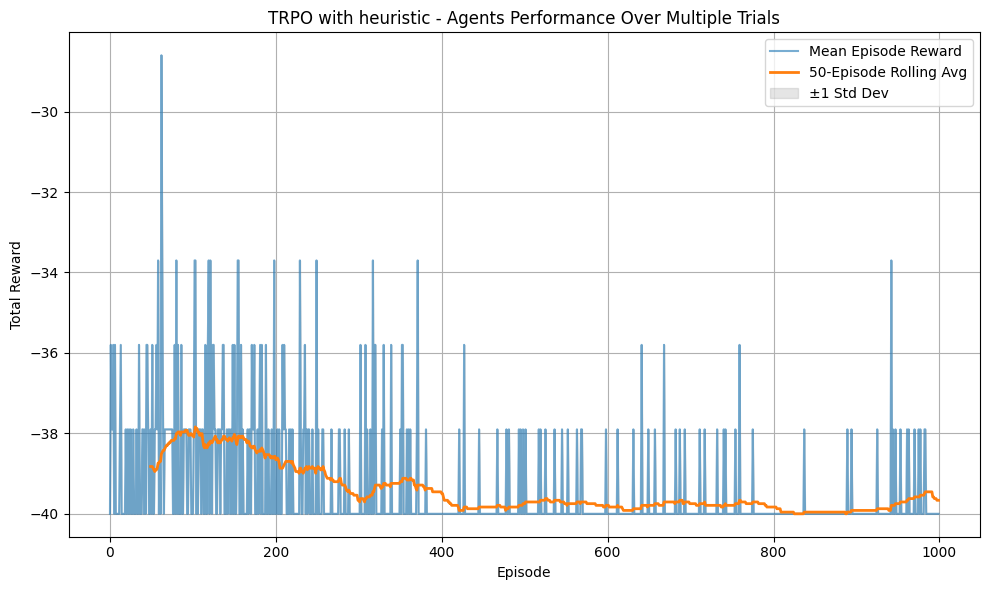

In [ ]:
agent0, rewards = train_trpo_with_heuristic(layout="small_l", episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma=0.99,
    max_kl=1e-2,
    cg_iters=10,
    damping=1e-2,
    ls_max_steps=10,
    ls_backtrack_coeff=0.8,
    lr=1e-3,
    update_epochs=10
)

plot_rewards(rewards, modelname= 'TRPO with heuristic')


Using device: cuda
TRPO+Heuristic Trial 1/1: 100%|██████████| 1000/1000 [09:47<00:00,  1.70it/s, Avg Reward=-38.32]


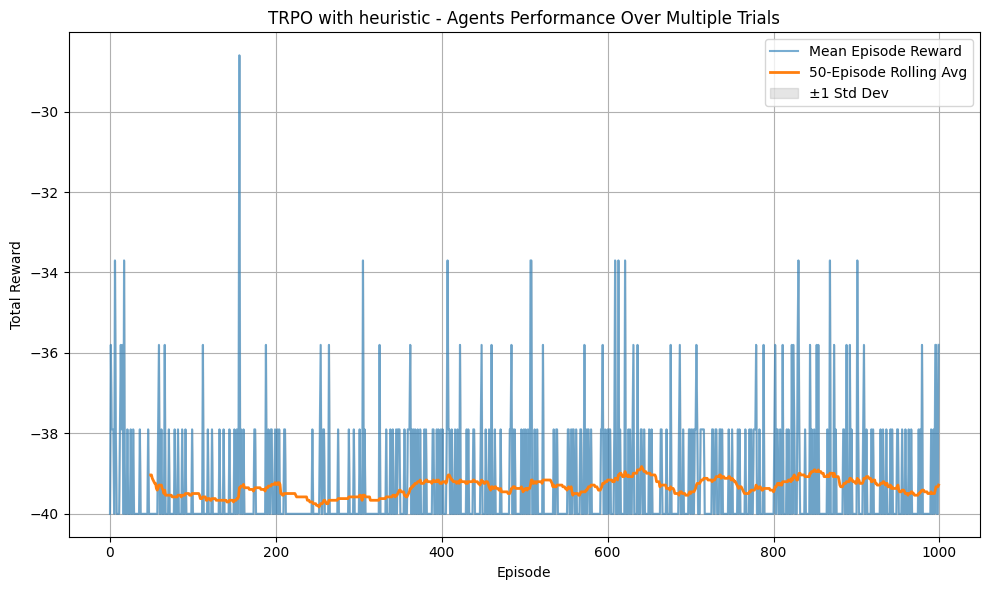

In [ ]:
agent0, rewards = train_trpo_with_heuristic(layout="small_l", episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma=0.99,
    max_kl=1e-3,
    cg_iters=5,
    damping=1e-2,
    ls_max_steps=10,
    ls_backtrack_coeff=0.8,
    lr=1e-3,
    update_epochs=10
)

plot_rewards(rewards, modelname= 'TRPO with heuristic')


Using device: cuda
TRPO+Heuristic Trial 1/1: 100%|██████████| 1000/1000 [10:13<00:00,  1.63it/s, Avg Reward=-40.00]


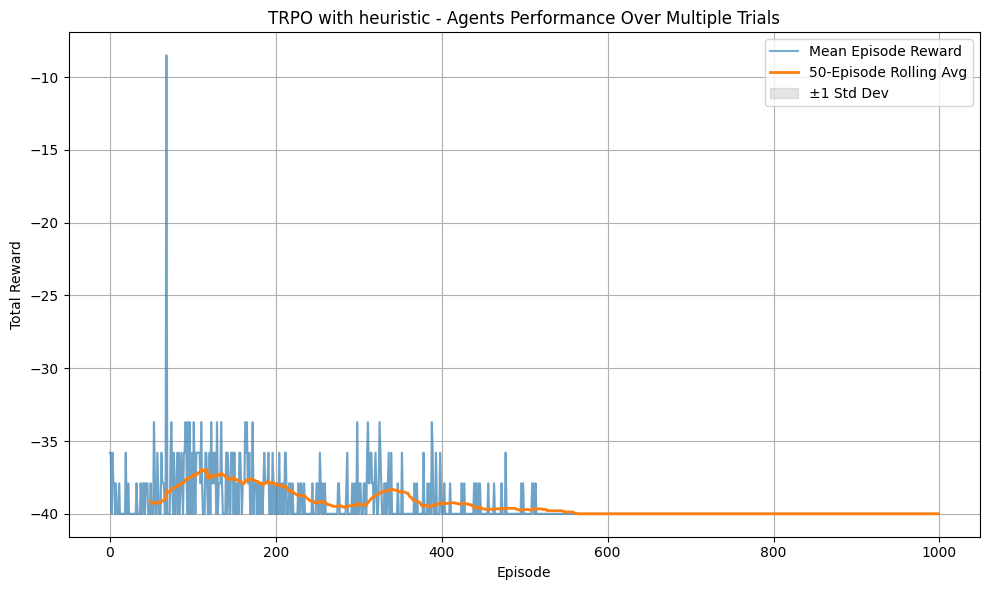

In [ ]:
agent0, rewards = train_trpo_with_heuristic(layout="small_l", episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma=0.999,
    max_kl=1e-2,
    cg_iters=10,
    damping=1e-2,
    ls_max_steps=15,
    ls_backtrack_coeff=0.8,
    lr=1e-3,
    update_epochs=10
)

plot_rewards(rewards, modelname= 'TRPO with heuristic')


Using device: cuda
TRPO+Heuristic Trial 1/1: 100%|██████████| 5000/5000 [50:59<00:00,  1.63it/s, Avg Reward=-40.00]


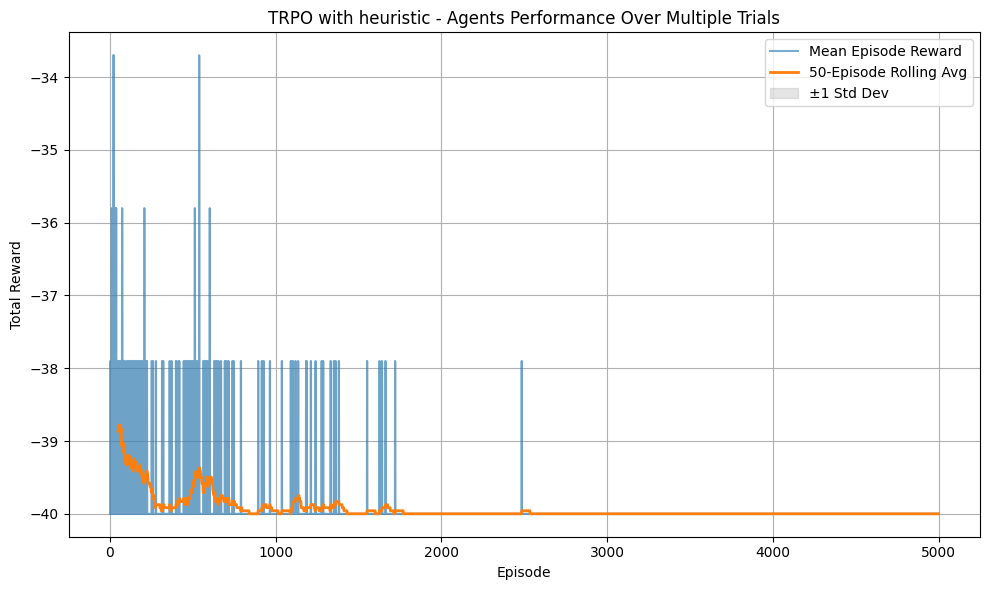

In [ ]:
agent0, rewards = train_trpo_with_heuristic(layout="small_l", episodes=5000,
    num_trials=1,
    max_steps=400,
    gamma=0.99,
    max_kl=1e-2,
    cg_iters=10,
    damping=1e-2,
    ls_max_steps=10,
    ls_backtrack_coeff=0.8,
    lr=1e-4,
    update_epochs=10
)

plot_rewards(rewards, modelname= 'TRPO with heuristic')


## 2 qlearning


In [ ]:

def train_two_agent_q_learning(episodes=500, layout='small_l', num_trials=1, max_steps=10000, alpha=0.1, gamma=0.99, epsilon=0.1):
    trial_rewards = []

    for trial in range(num_trials):
        env = Overcooked(
            layout=layout,
            max_timesteps=max_steps,
            rewards=(-0.1, 2, 5, 20)  # shaped rewards: move, add onion, pickup soup, deliver
        )
        agent0 = QLearningAgent(env, alpha=alpha, gamma=gamma, epsilon=epsilon)
        agent1 = QLearningAgent(env, alpha=alpha, gamma=gamma, epsilon=epsilon)

        episode_rewards = []
        progress_bar = tqdm(range(episodes), desc=f"Trial {trial+1}/{num_trials}", file=sys.stdout)

        for ep in progress_bar:
            state = env.reset()
            total_reward = 0
            done = False
            t = 0

            while not done and t < max_steps:
                a0 = agent0.select_action(state)
                a1 = agent1.select_action(state)
                joint_action = env.pack_joint_action(a0, a1)
                next_state, reward, done, _ = env.step(joint_action)

                agent0.update(state, a0, reward, next_state)
                agent1.update(state, a1, reward, next_state)

                state = next_state
                total_reward += reward
                t += 1

            episode_rewards.append(total_reward)
            avg_reward = np.mean(episode_rewards[-10:])
            progress_bar.set_postfix({"Avg Reward": f"{avg_reward:.2f}"})

        trial_rewards.append(episode_rewards)

    return agent0, agent1, np.array(trial_rewards)


Trial 1/1: 100%|██████████| 1000/1000 [00:19<00:00, 50.20it/s, Avg Reward=242.42]


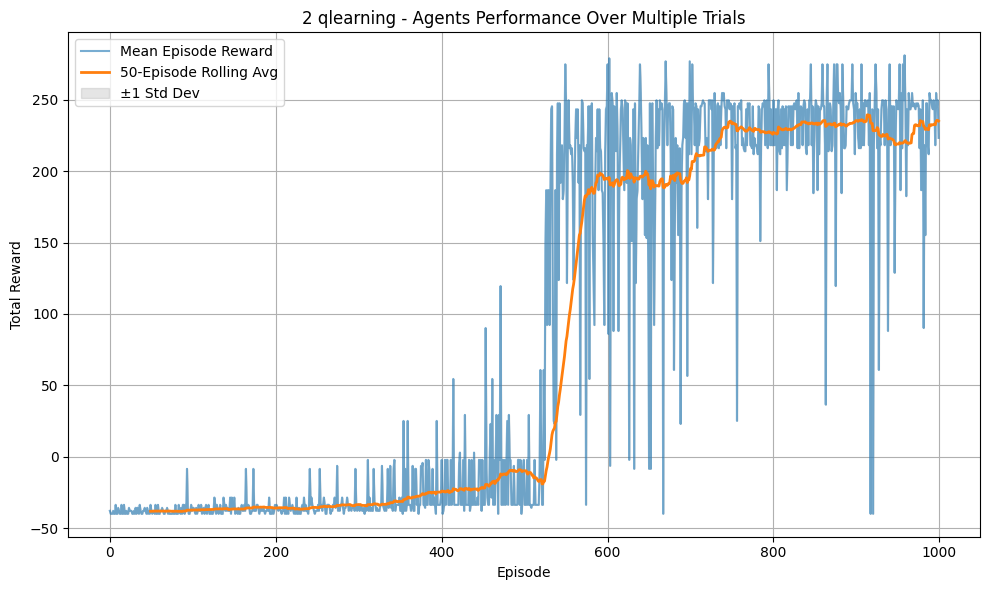

In [ ]:
agent_q0, agent_q1, rewards = train_two_agent_q_learning(episodes=1000, layout='small_l', num_trials=1, max_steps=400, alpha=0.1, gamma=0.99, epsilon=0.1)
plot_rewards(rewards, modelname= '2 qlearning')


Trial 1/1: 100%|██████████| 1000/1000 [00:19<00:00, 50.63it/s, Avg Reward=203.60]


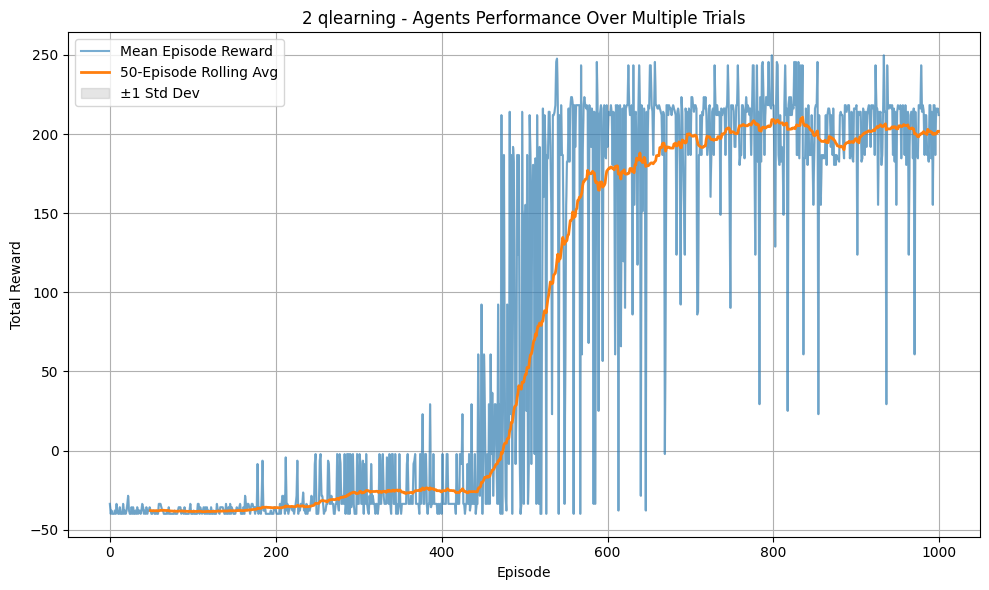

In [ ]:
agent_q0, agent_q1, rewards = train_two_agent_q_learning(episodes=1000, layout='small_l', num_trials=1, max_steps=400, alpha=0.2, gamma=0.99, epsilon=0.1)
plot_rewards(rewards, modelname= '2 qlearning')


Trial 1/1: 100%|██████████| 1000/1000 [00:19<00:00, 51.12it/s, Avg Reward=156.23]


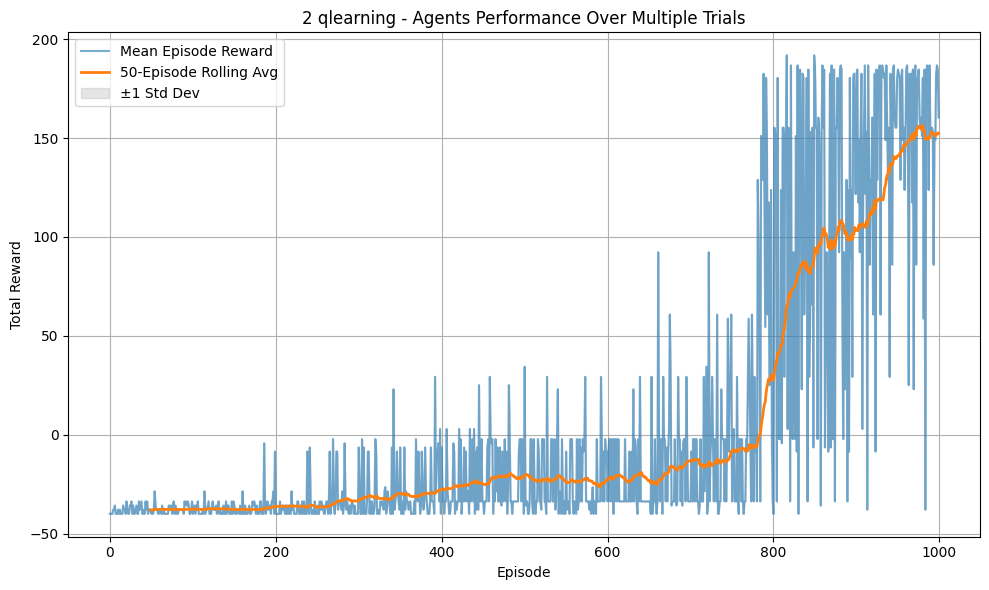

In [ ]:
agent_q0, agent_q1, rewards = train_two_agent_q_learning(episodes=1000, layout='small_l', num_trials=1, max_steps=400, alpha=0.1, gamma=0.99, epsilon=0.2)
plot_rewards(rewards, modelname= '2 qlearning')


Trial 1/1: 100%|██████████| 1000/1000 [00:18<00:00, 53.06it/s, Avg Reward=273.32]


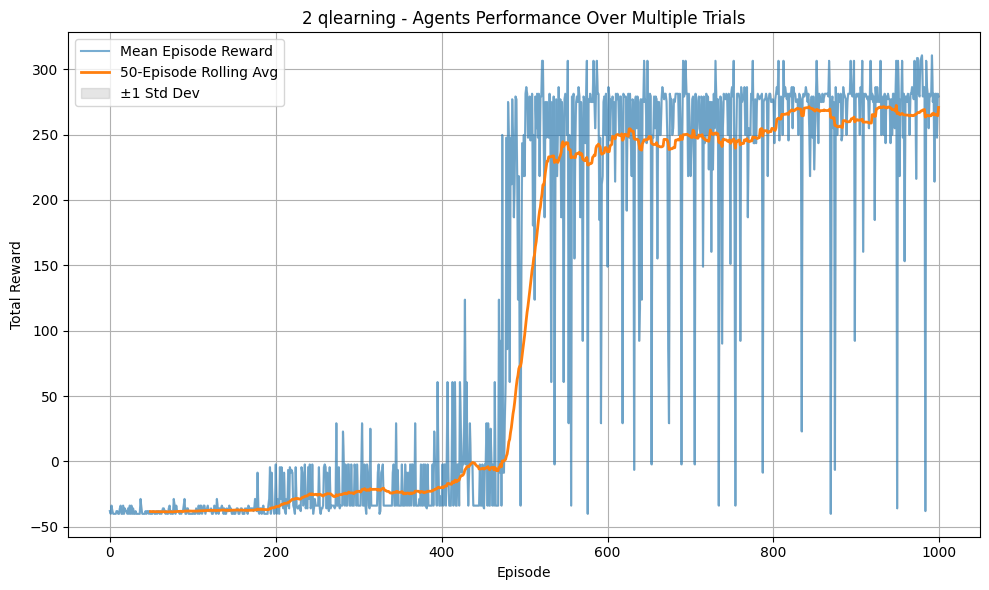

In [ ]:
agent_q0, agent_q1, rewards = train_two_agent_q_learning(episodes=1000, layout='small_l', num_trials=1, max_steps=400, alpha=0.1, gamma=0.99, epsilon=0.05)
plot_rewards(rewards, modelname= '2 qlearning')


In [ ]:
import numpy as np
from tqdm import tqdm
import sys

def evaluate_trained_q_agents(agent0, agent1, layout='corridor', episodes=10, max_steps=400, num_trials=1):
    """
    Evaluate pre-trained Q-learning agents on a new Overcooked layout.
    Returns: np.array of shape (num_trials, episodes)
    """
    agent0.epsilon = 0  # Greedy behavior during evaluation
    agent1.epsilon = 0

    all_trial_rewards = []

    for trial in range(num_trials):
        env = Overcooked(
            layout=layout,
            max_timesteps=max_steps,
            rewards=(-0.1, 2, 5, 20)
        )

        episode_rewards = []
        progress_bar = tqdm(range(episodes), desc=f"Evaluating on {layout} | Trial {trial+1}/{num_trials}", file=sys.stdout)

        for ep in progress_bar:
            state = env.reset()
            total_reward = 0
            done = False
            t = 0

            while not done and t < max_steps:
                a0 = agent0.select_action(state)
                a1 = agent1.select_action(state)
                joint_action = env.pack_joint_action(a0, a1)
                next_state, reward, done, _ = env.step(joint_action)

                state = next_state
                total_reward += reward
                t += 1

            episode_rewards.append(total_reward)
            avg_reward = np.mean(episode_rewards[-5:])
            progress_bar.set_postfix({"Avg Reward (last 5)": f"{avg_reward:.2f}"})

        all_trial_rewards.append(episode_rewards)

    return np.array(all_trial_rewards)


Evaluating on simple_kitchen | Trial 1/1: 100%|██████████| 1000/1000 [00:10<00:00, 99.06it/s, Avg Reward (last 5)=-40.00]


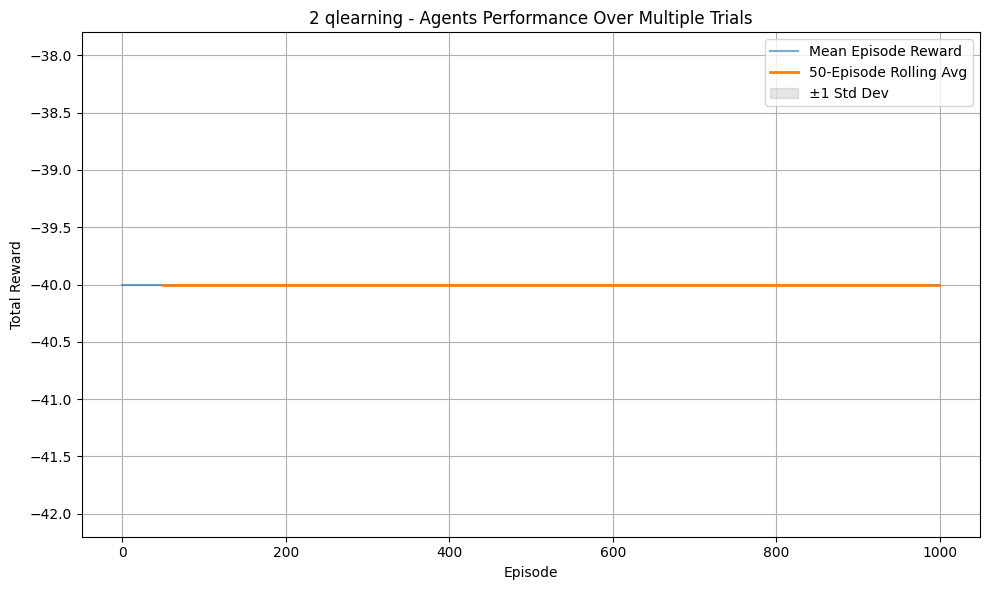

In [ ]:
evaluation_rewards = evaluate_trained_q_agents(agent_q0, agent_q1, layout='simple_kitchen', episodes=1000, max_steps=400)
plot_rewards(evaluation_rewards, modelname= '2 qlearning')

## 2 DQN

In [ ]:
def train_two_dqn_agents(episodes=1000, layout='small_l', num_trials=1, max_steps=100, gamma = 0.99,
        epsilon = 1.0,
        epsilon_decay = 0.995,
        min_epsilon = 0.1,
        batch_size = 64,
        update_target_every = 20, lr=1e-2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    trial_rewards = []

    for trial in range(num_trials):
        env = Overcooked(layout=layout, max_timesteps=max_steps)
        input_dim = env.one_hot_encoding(env.reset()).shape[0]
        output_dim = env.num_actions

        # Agent 0
        q_net0, target_net0 = DQN(input_dim, output_dim).to(device), DQN(input_dim, output_dim).to(device)
        target_net0.load_state_dict(q_net0.state_dict())
        optimizer0 = optim.Adam(q_net0.parameters(), lr=lr)
        buffer0 = ReplayBuffer(capacity=100000)

        # Agent 1
        q_net1, target_net1 = DQN(input_dim, output_dim).to(device), DQN(input_dim, output_dim).to(device)
        target_net1.load_state_dict(q_net1.state_dict())
        optimizer1 = optim.Adam(q_net1.parameters(), lr=lr)
        buffer1 = ReplayBuffer(capacity=100000)

        target_net0.eval()
        target_net1.eval()

        episode_rewards = []
        progress_bar = tqdm(range(episodes), desc=f"DQN Trial {trial+1}/{num_trials}", file=sys.stdout)

        for ep in progress_bar:
            state = env.reset()
            state_encoded = env.one_hot_encoding(state)
            total_reward = 0
            done = False
            step_count = 0

            while not done and step_count < max_steps:
                state_tensor = torch.FloatTensor(state_encoded).unsqueeze(0).to(device)

                # --- Agent 0 ---
                if random.random() < epsilon:
                    a0 = random.randint(0, output_dim - 1)
                else:
                    with torch.no_grad():
                        a0 = q_net0(state_tensor).argmax().item()

                # --- Agent 1 ---
                if random.random() < epsilon:
                    a1 = random.randint(0, output_dim - 1)
                else:
                    with torch.no_grad():
                        a1 = q_net1(state_tensor).argmax().item()

                joint_action = env.pack_joint_action(a0, a1)
                next_state, reward, done, _ = env.step(joint_action)
                next_state_encoded = env.one_hot_encoding(next_state)

                # Cache transitions
                buffer0.push(state_encoded, a0, reward, next_state_encoded, done)
                buffer1.push(state_encoded, a1, reward, next_state_encoded, done)

                state = next_state
                state_encoded = next_state_encoded
                total_reward += reward
                step_count += 1

                # Optimize Agent 0
                if len(buffer0) >= 1000:
                    s_batch, a_batch, r_batch, s2_batch, d_batch = buffer0.sample(batch_size)
                    s_batch = torch.FloatTensor(s_batch).to(device)
                    a_batch = torch.LongTensor(a_batch).to(device)
                    r_batch = torch.FloatTensor(r_batch).to(device)
                    s2_batch = torch.FloatTensor(s2_batch).to(device)
                    d_batch = torch.FloatTensor(d_batch).to(device)

                    q_vals = q_net0(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze()
                    with torch.no_grad():
                        next_q_vals = target_net0(s2_batch).max(1)[0]
                    target = r_batch + gamma * next_q_vals * (1 - d_batch)

                    loss = nn.MSELoss()(q_vals, target)
                    optimizer0.zero_grad()
                    loss.backward()
                    optimizer0.step()

                # Optimize Agent 1
                if len(buffer1) >= 1000:
                    s_batch, a_batch, r_batch, s2_batch, d_batch = buffer1.sample(batch_size)
                    s_batch = torch.FloatTensor(s_batch).to(device)
                    a_batch = torch.LongTensor(a_batch).to(device)
                    r_batch = torch.FloatTensor(r_batch).to(device)
                    s2_batch = torch.FloatTensor(s2_batch).to(device)
                    d_batch = torch.FloatTensor(d_batch).to(device)

                    q_vals = q_net1(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze()
                    with torch.no_grad():
                        next_q_vals = target_net1(s2_batch).max(1)[0]
                    target = r_batch + gamma * next_q_vals * (1 - d_batch)

                    loss = nn.MSELoss()(q_vals, target)
                    optimizer1.zero_grad()
                    loss.backward()
                    optimizer1.step()

            episode_rewards.append(total_reward)
            avg_reward = np.mean(episode_rewards[-10:])
            progress_bar.set_postfix({"Avg Reward": f"{avg_reward:.2f}"})

            if ep % update_target_every == 0:
                target_net0.load_state_dict(q_net0.state_dict())
                target_net1.load_state_dict(q_net1.state_dict())

            epsilon = max(min_epsilon, epsilon * epsilon_decay)

        trial_rewards.append(episode_rewards)

    return q_net0, q_net1, np.array(trial_rewards)


Using device: cuda
DQN Trial 1/1: 100%|██████████| 1000/1000 [39:54<00:00,  2.39s/it, Avg Reward=-33.70]


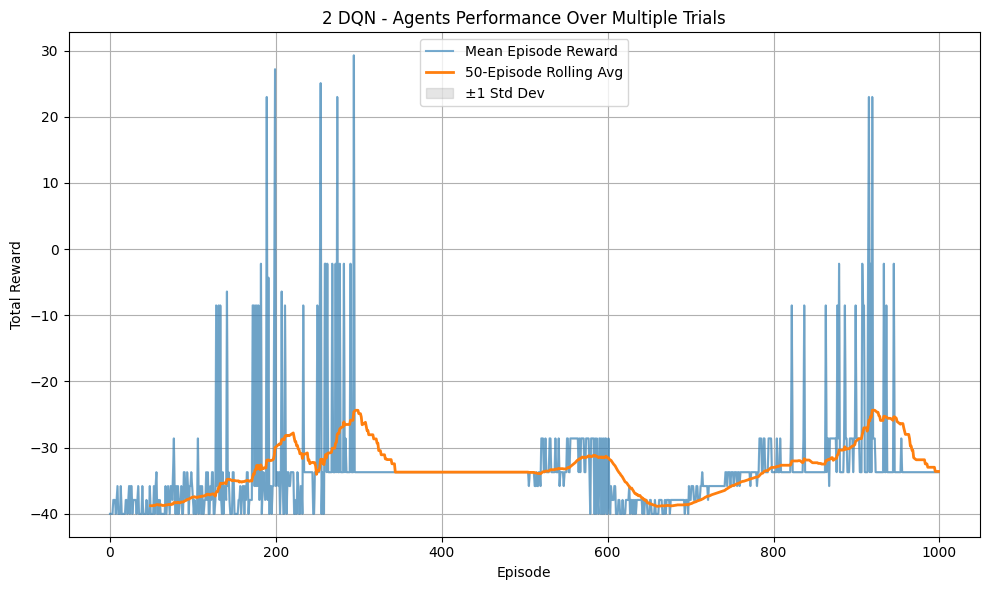

In [ ]:
agent0, agent1, rewards = train_two_dqn_agents(episodes=1000, layout='small_l', num_trials=1, max_steps=400, gamma = 0.99,
        epsilon = 1.0,
        epsilon_decay = 0.995,
        min_epsilon = 0.1,
        batch_size =128,
        update_target_every = 20, lr=1e-4)
plot_rewards(rewards, window=50, modelname='2 DQN')


Using device: cuda
DQN Trial 1/1: 100%|██████████| 1000/1000 [39:30<00:00,  2.37s/it, Avg Reward=59.84]


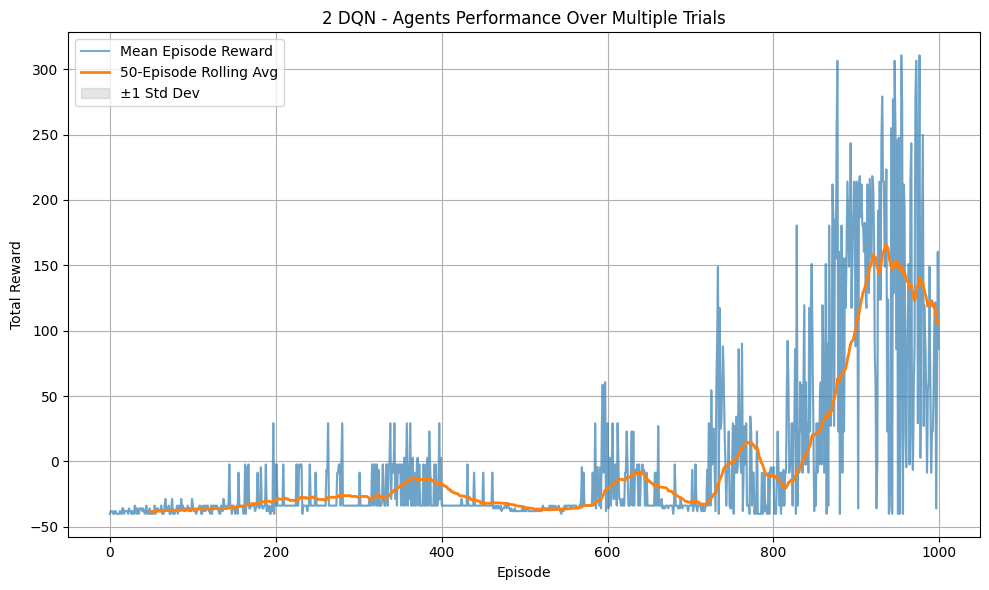

In [ ]:
agent0, agent1, rewards = train_two_dqn_agents(episodes=1000, layout='small_l', num_trials=1, max_steps=400, gamma = 0.99,
        epsilon = 1.0,
        epsilon_decay = 0.995,
        min_epsilon = 0.1,
        batch_size =128,
        update_target_every = 20, lr=1e-4)
plot_rewards(rewards, window=50, modelname='2 DQN')


Using device: cuda
DQN Trial 1/1: 100%|██████████| 1000/1000 [35:09<00:00,  2.11s/it, Avg Reward=-34.12]


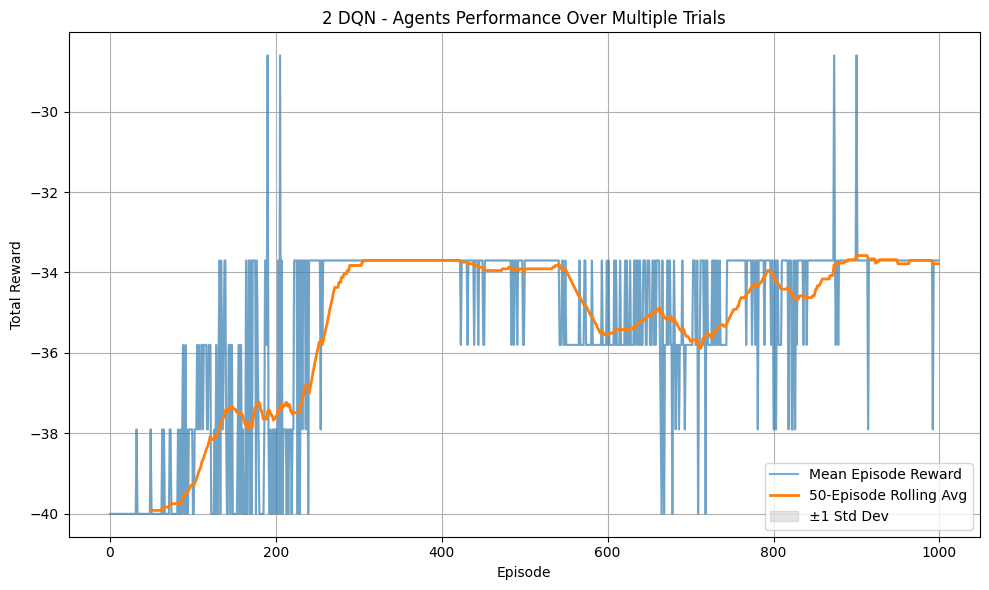

In [ ]:
agent0, agent1, rewards = train_two_dqn_agents(episodes=1000, layout='small_l', num_trials=1, max_steps=400, gamma = 0.99,
        epsilon = 0.1,
        epsilon_decay = 1,
        min_epsilon = 0.1,
        batch_size = 64,
        update_target_every = 20, lr=1e-4)
plot_rewards(rewards, window=50, modelname='2 DQN')

Using device: cuda
DQN Trial 1/1: 100%|██████████| 1000/1000 [36:23<00:00,  2.18s/it, Avg Reward=-40.00]


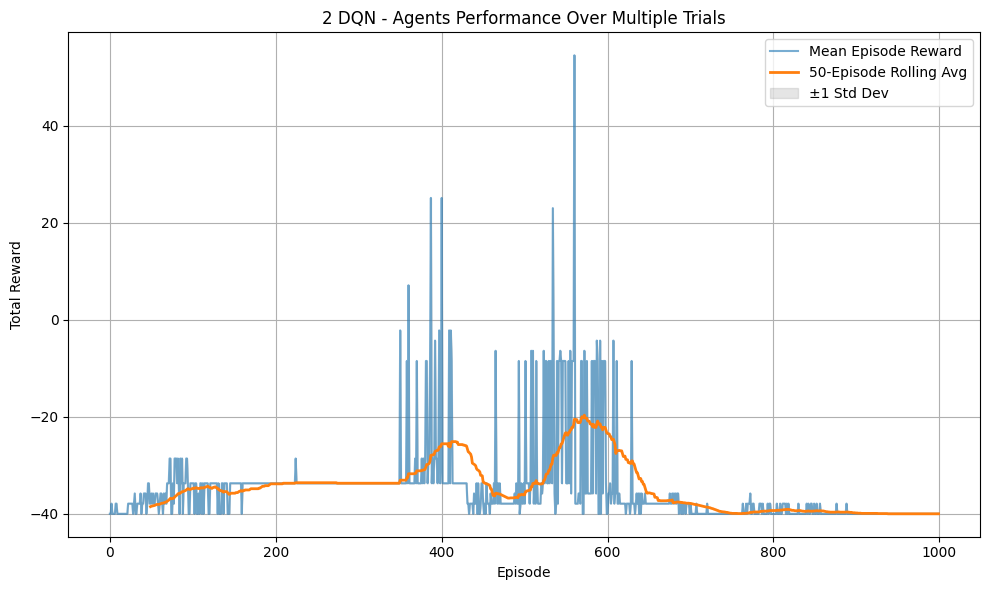

In [ ]:
agent0, agent1, rewards = train_two_dqn_agents(episodes=1000, layout='small_l', num_trials=1, max_steps=400, gamma = 0.99,
        epsilon = 0.2,
        epsilon_decay = 1,
        min_epsilon = 0.2,
        batch_size = 64,
        update_target_every = 20, lr=1e-4)
plot_rewards(rewards, window=50, modelname='2 DQN')

Using device: cuda
DQN Trial 1/1: 100%|██████████| 1000/1000 [35:16<00:00,  2.12s/it, Avg Reward=-33.70]


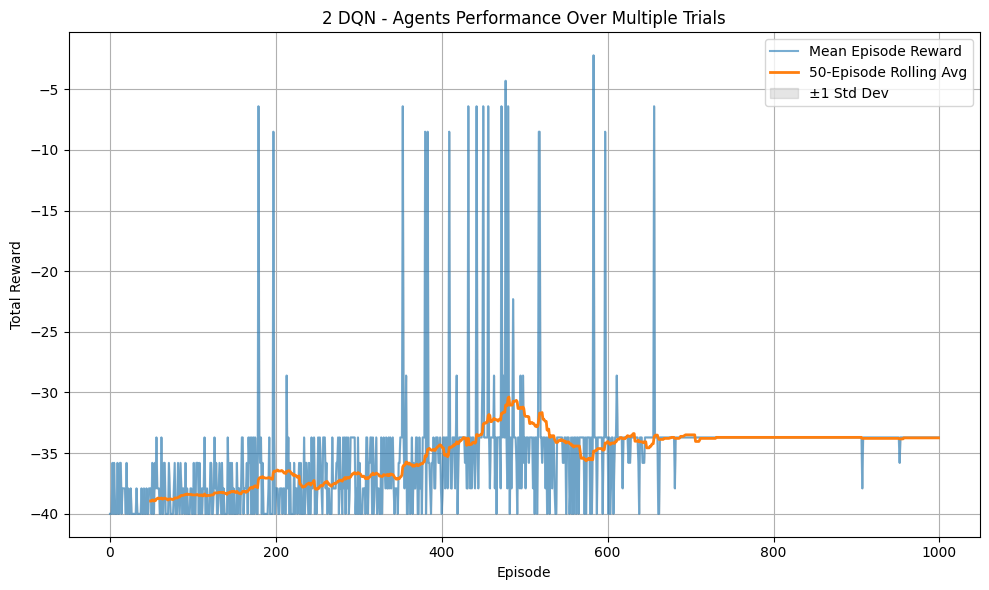

In [ ]:
agent0, agent1, rewards = train_two_dqn_agents(episodes=1000, layout='small_l', num_trials=1, max_steps=400, gamma = 0.99,
        epsilon = 1,
        epsilon_decay = 0.999,
        min_epsilon = 0.05,
        batch_size = 64,
        update_target_every = 20, lr=1e-5)
plot_rewards(rewards, window=50, modelname='2 DQN')

Using device: cuda
DQN Trial 1/1: 100%|██████████| 1000/1000 [37:17<00:00,  2.24s/it, Avg Reward=-33.70]


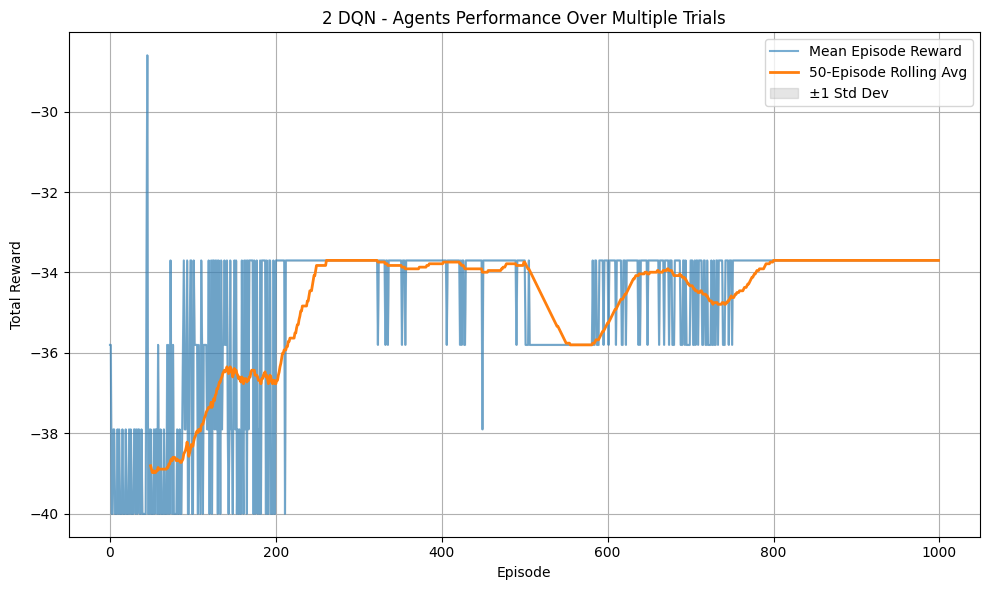

In [ ]:
agent0, agent1, rewards = train_two_dqn_agents(episodes=1000, layout='small_l', num_trials=1, max_steps=400, gamma = 0.99,
        epsilon = 1,
        epsilon_decay = 0.99,
        min_epsilon = 0.05,
        batch_size = 64,
        update_target_every = 20, lr=1e-4)
plot_rewards(rewards, window=50, modelname='2 DQN')

Using device: cuda
DQN Trial 1/1: 100%|██████████| 5000/5000 [3:22:37<00:00,  2.43s/it, Avg Reward=-38.32]


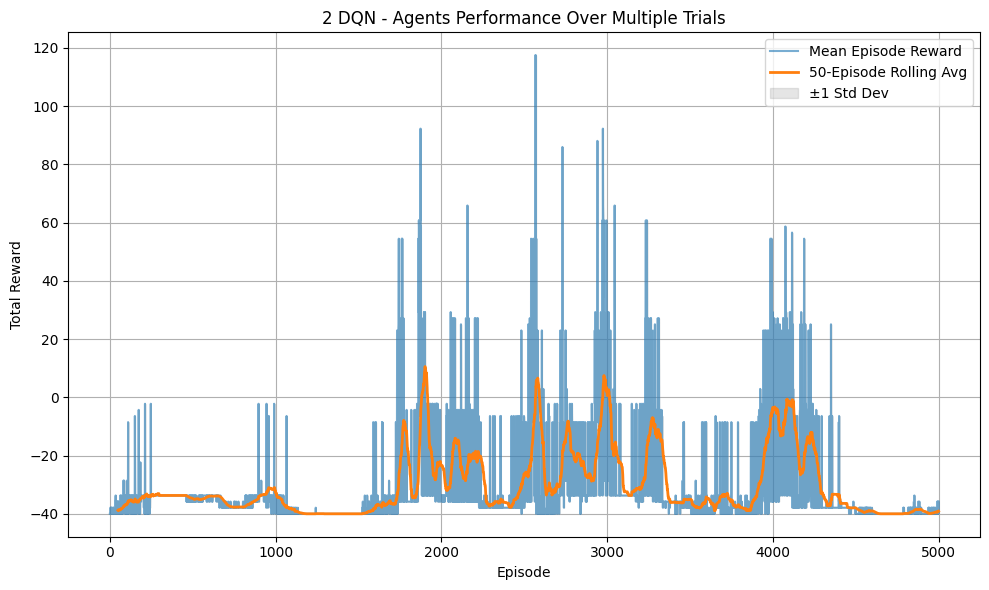

In [ ]:
agent0, agent1, rewards = train_two_dqn_agents(episodes=5000, layout='small_l', num_trials=1, max_steps=400, gamma = 0.99,
        epsilon = 1.0,
        epsilon_decay = 0.995,
        min_epsilon = 0.1,
        batch_size =128,
        update_target_every = 20, lr=1e-4)
plot_rewards(rewards, window=50, modelname='2 DQN')

Using device: cuda
DQN Trial 1/1: 100%|██████████| 5000/5000 [3:21:58<00:00,  2.42s/it, Avg Reward=169.46]


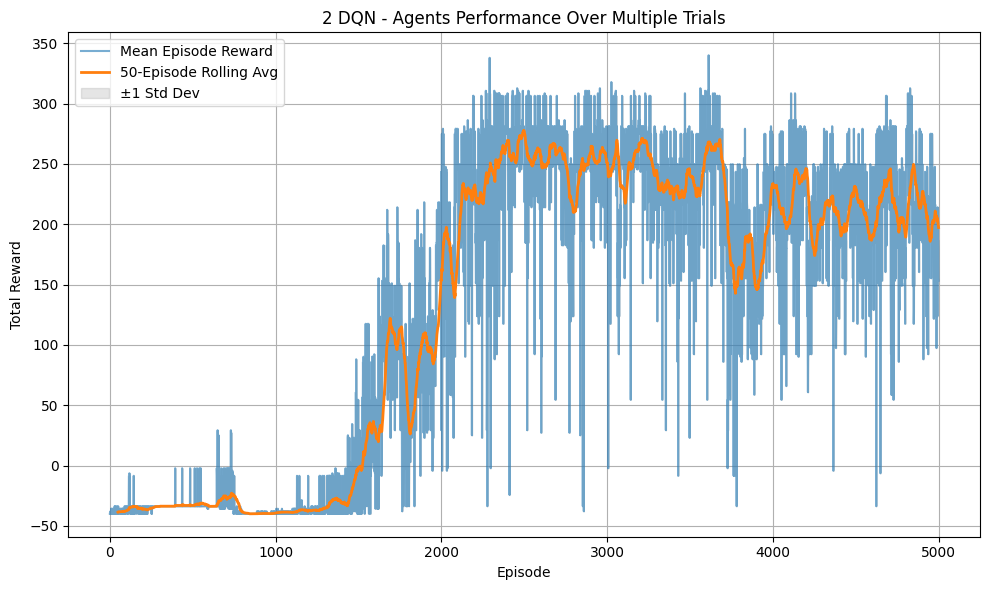

In [ ]:
agent0, agent1, rewards = train_two_dqn_agents(episodes=5000, layout='small_l', num_trials=1, max_steps=400, gamma = 0.99,
        epsilon = 1.0,
        epsilon_decay = 0.995,
        min_epsilon = 0.2,
        batch_size =128,
        update_target_every = 20, lr=1e-4)
plot_rewards(rewards, window=50, modelname='2 DQN')


## 2 PPO

In [ ]:
def train_two_ppo_agents(episodes=500, maxstep=200, layout='small_l', num_trials=1, gamma=0.99, lr=1e-3, eps_clip=0.2, K_epochs=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    trial_rewards = []

    for trial in range(num_trials):
        env = Overcooked(layout=layout, max_timesteps=maxstep)
        agent0 = PPOAgent(env, gamma=gamma, lr=lr, eps_clip=eps_clip, K_epochs=K_epochs, device=device)
        agent1 = PPOAgent(env, gamma=gamma, lr=lr, eps_clip=eps_clip, K_epochs=K_epochs, device=device)
        episode_rewards = []

        progress_bar = tqdm(range(episodes), desc=f"PPO Trial {trial+1}/{num_trials}", file=sys.stdout)

        for ep in progress_bar:
            state = env.reset()
            total_reward = 0

            for _ in range(maxstep):
                state_vec = torch.FloatTensor(env.one_hot_encoding(state)).to(device)
                a0, log_prob0, value0 = agent0.select_action(state_vec)
                a1, log_prob1, value1 = agent1.select_action(state_vec)
                joint_action = env.pack_joint_action(a0, a1)
                next_state, reward, done, _ = env.step(joint_action)

                # Store buffer data — keep log_probs/values as GPU tensors
                agent0.buffer.states.append(state_vec)
                agent0.buffer.actions.append(a0)
                agent0.buffer.log_probs.append(log_prob0)
                agent0.buffer.rewards.append(reward)
                agent0.buffer.dones.append(float(done))
                agent0.buffer.values.append(value0)

                agent1.buffer.states.append(state_vec)
                agent1.buffer.actions.append(a1)
                agent1.buffer.log_probs.append(log_prob1)
                agent1.buffer.rewards.append(reward)
                agent1.buffer.dones.append(float(done))
                agent1.buffer.values.append(value1)

                state = next_state
                total_reward += reward

            # Bootstrap
            next_state_vec = env.one_hot_encoding(state)
            next_state_tensor = torch.FloatTensor(next_state_vec).unsqueeze(0).to(device)
            with torch.no_grad():
                _, next_value0 = agent0.policy(next_state_tensor)
                _, next_value1 = agent1.policy(next_state_tensor)
            agent0.buffer.values.append(next_value0.squeeze())
            agent1.buffer.values.append(next_value1.squeeze())

            agent0.update()
            agent1.update()
            episode_rewards.append(total_reward)

            avg_reward = np.mean(episode_rewards[-10:])
            progress_bar.set_postfix({"Avg Reward": f"{avg_reward:.2f}"})

        trial_rewards.append(episode_rewards)

    return agent0, agent1, np.array(trial_rewards)


Using device: cuda
PPO Trial 1/1: 100%|██████████| 1000/1000 [17:39<00:00,  1.06s/it, Avg Reward=-39.16]


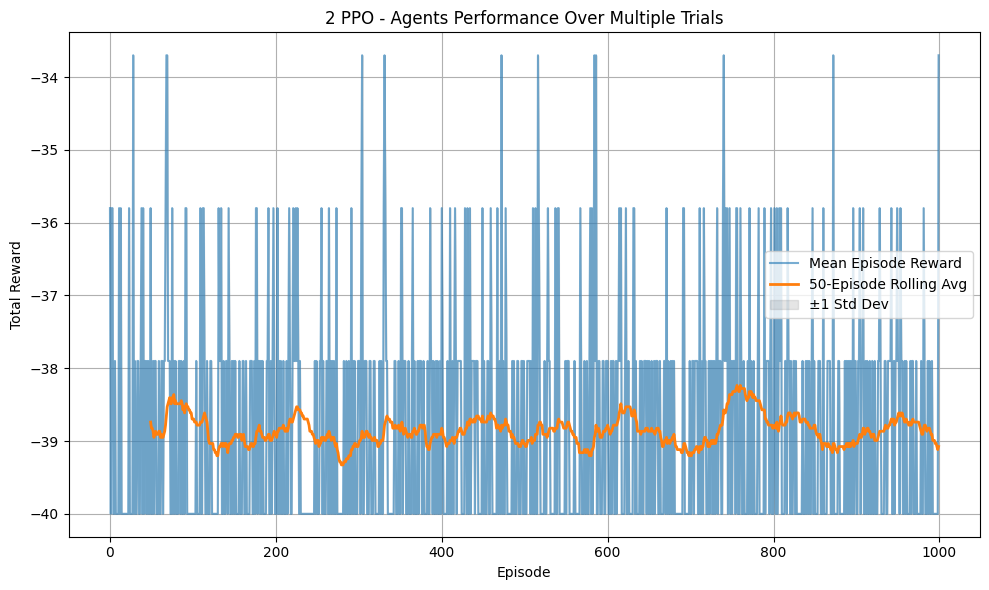

In [ ]:
agent0, agent1, rewards = train_two_ppo_agents(episodes=1000, maxstep=400, layout='small_l', num_trials=1, gamma=0.99, lr=1e-2, eps_clip=0.2, K_epochs=8)
plot_rewards(rewards, window=50, modelname='2 PPO')


Using device: cuda
PPO Trial 1/1: 100%|██████████| 1000/1000 [17:34<00:00,  1.05s/it, Avg Reward=-35.80]


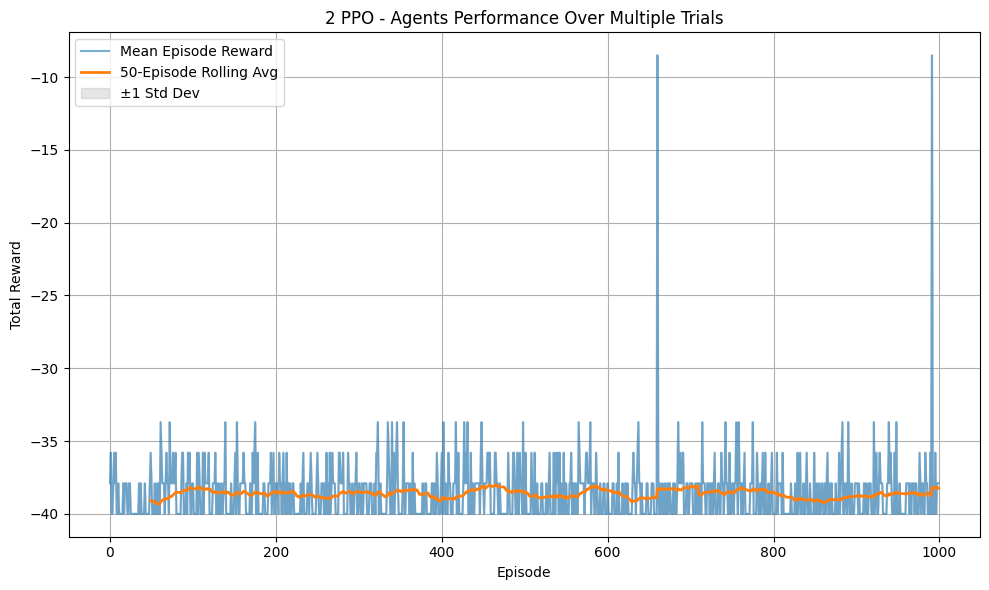

In [ ]:
agent0, agent1, rewards = train_two_ppo_agents(episodes=1000, maxstep=400, layout='small_l', num_trials=1, gamma=0.99, lr=1e-3, eps_clip=0.2, K_epochs=8)
plot_rewards(rewards, window=50, modelname='2 PPO')


Using device: cuda
PPO Trial 1/1: 100%|██████████| 1000/1000 [17:33<00:00,  1.05s/it, Avg Reward=-39.16]


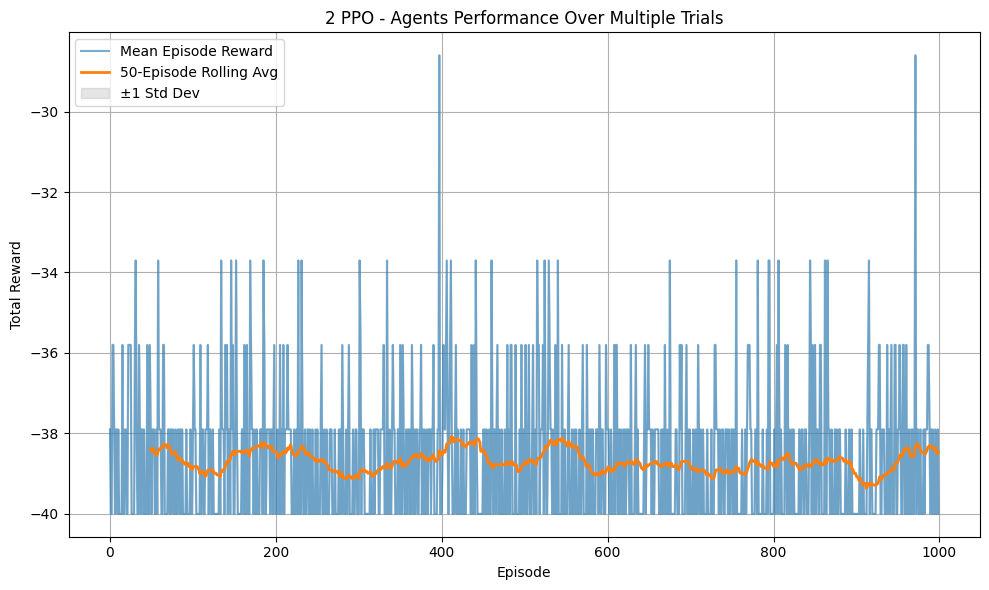

In [ ]:
agent0, agent1, rewards = train_two_ppo_agents(episodes=1000, maxstep=400, layout='small_l', num_trials=1, gamma=0.99, lr=1e-4, eps_clip=0.2, K_epochs=8)
plot_rewards(rewards, window=50, modelname='2 PPO')


Using device: cuda
PPO Trial 1/1: 100%|██████████| 1000/1000 [17:30<00:00,  1.05s/it, Avg Reward=-38.74]


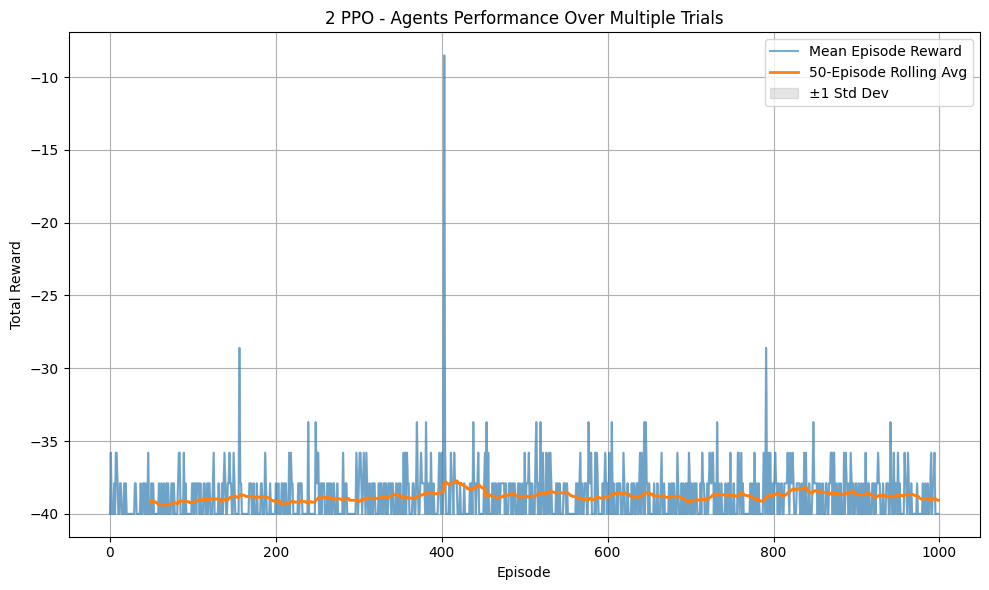

In [ ]:
agent0, agent1, rewards = train_two_ppo_agents(episodes=1000, maxstep=400, layout='small_l', num_trials=1, gamma=0.99, lr=1e-5, eps_clip=0.2, K_epochs=8)
plot_rewards(rewards, window=50, modelname='2 PPO')


Using device: cuda
PPO Trial 1/1: 100%|██████████| 1000/1000 [17:37<00:00,  1.06s/it, Avg Reward=-38.32]


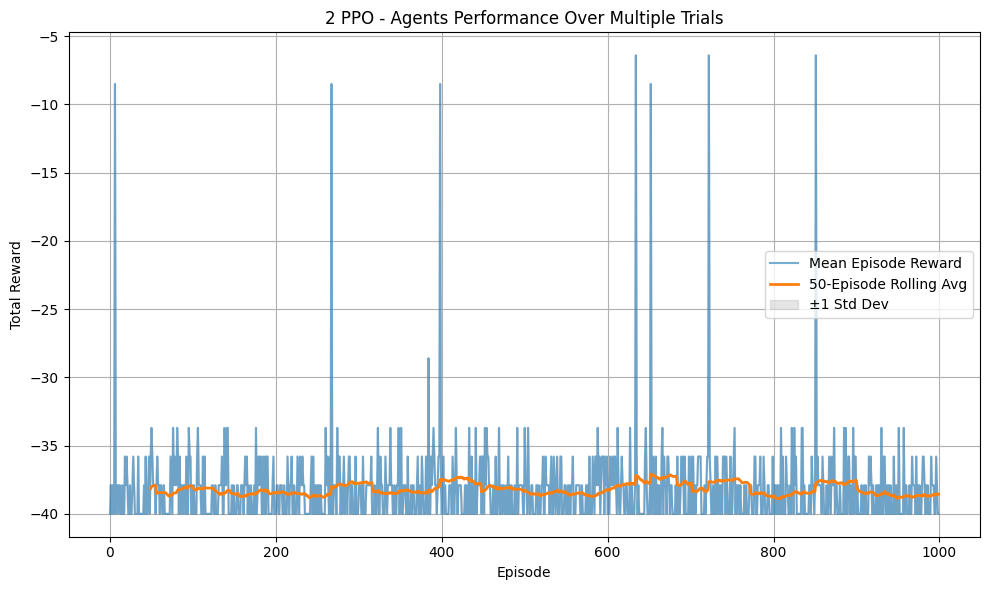

In [ ]:
agent0, agent1, rewards = train_two_ppo_agents(episodes=1000, maxstep=400, layout='small_l', num_trials=1, gamma=0.95, lr=1e-3, eps_clip=0.2, K_epochs=8)
plot_rewards(rewards, window=50, modelname='2 PPO')


Using device: cuda
PPO Trial 1/1: 100%|██████████| 1000/1000 [17:36<00:00,  1.06s/it, Avg Reward=-39.37]


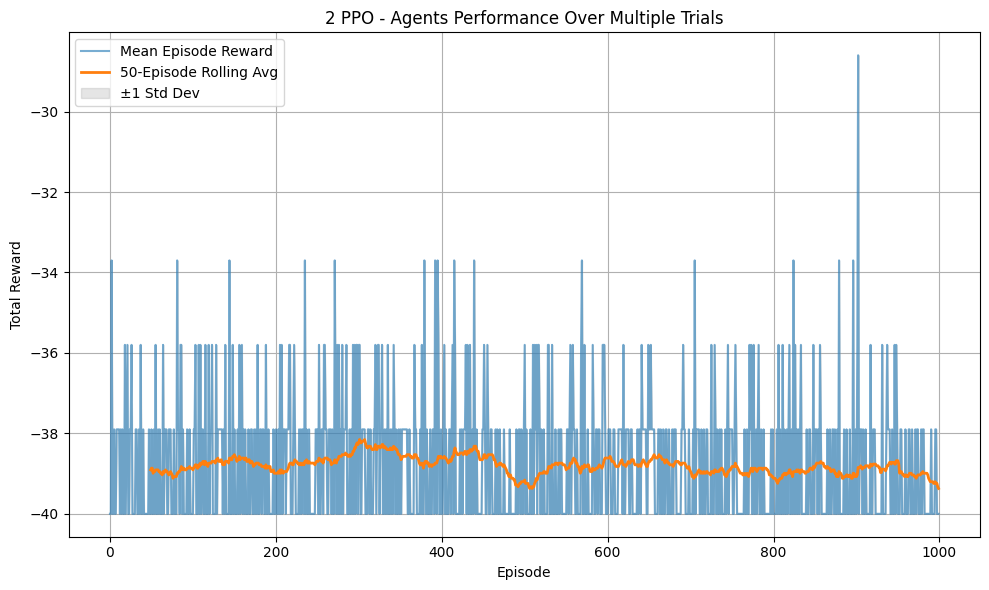

In [ ]:
agent0, agent1, rewards = train_two_ppo_agents(episodes=1000, maxstep=400, layout='small_l', num_trials=1, gamma=0.99, lr=1e-3, eps_clip=0.1
, K_epochs=8)
plot_rewards(rewards, window=50, modelname='2 PPO')


Using device: cuda
PPO Trial 1/1: 100%|██████████| 1000/1000 [17:09<00:00,  1.03s/it, Avg Reward=-39.16]


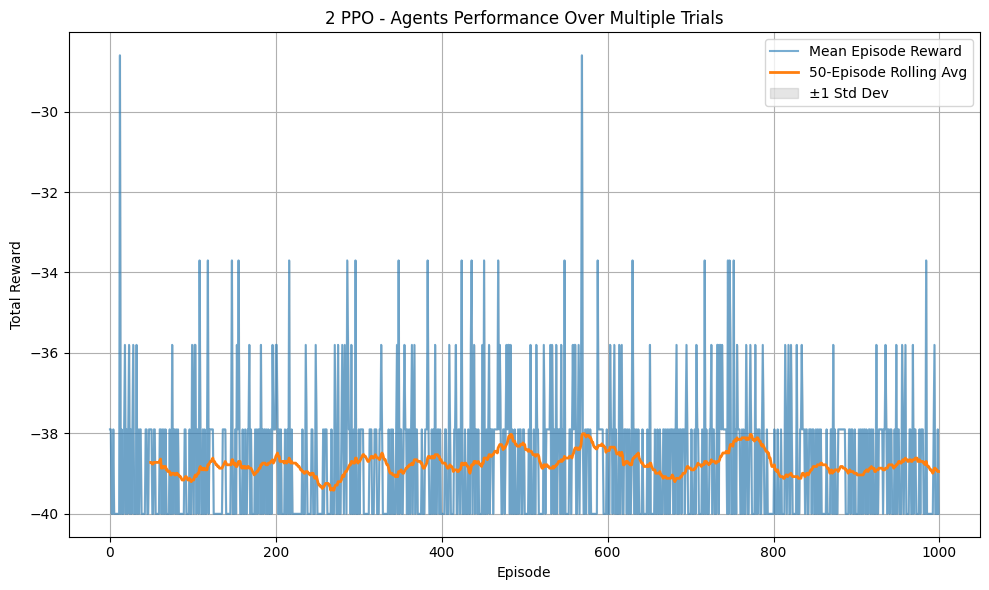

In [ ]:
agent0, agent1, rewards = train_two_ppo_agents(episodes=1000, maxstep=400, layout='small_l', num_trials=1, gamma=0.99, lr=1e-3, eps_clip=0.2, K_epochs=4)
plot_rewards(rewards, window=50, modelname='2 PPO')


Using device: cuda
PPO Trial 1/1: 100%|██████████| 1000/1000 [17:41<00:00,  1.06s/it, Avg Reward=-38.95]


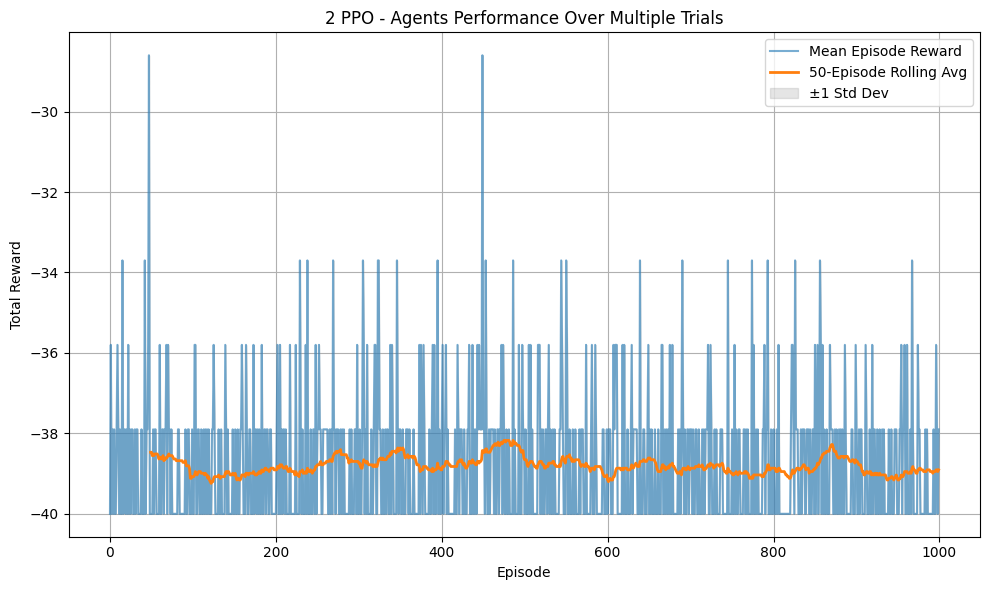

In [ ]:
agent0, agent1, rewards = train_two_ppo_agents(episodes=1000, maxstep=400, layout='small_l', num_trials=1, gamma=0.95, lr=1e-2, eps_clip=0.2, K_epochs=8)
plot_rewards(rewards, window=50, modelname='2 PPO')


Using device: cuda
PPO Trial 1/1: 100%|██████████| 1000/1000 [17:50<00:00,  1.07s/it, Avg Reward=-34.75]


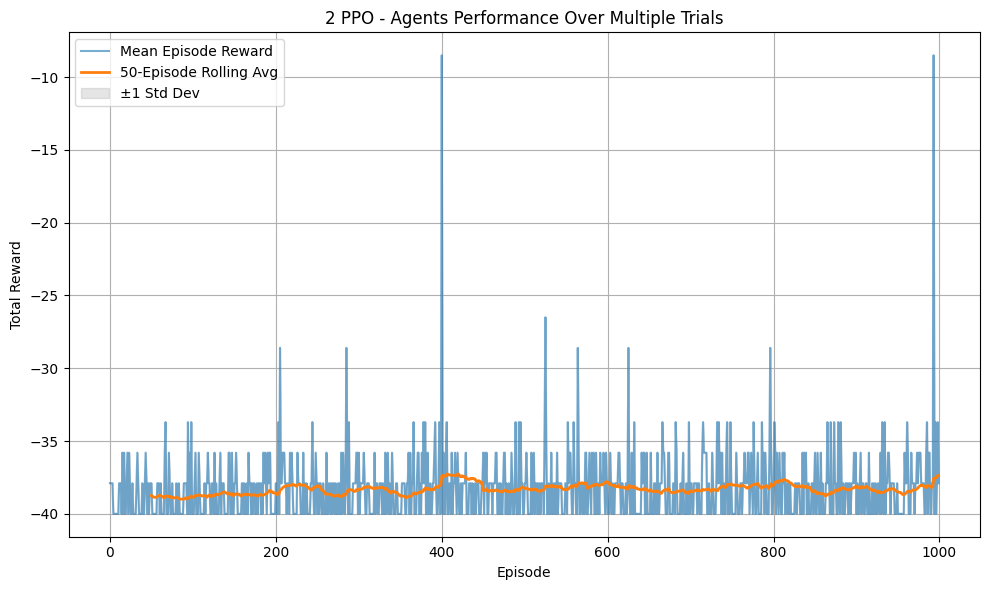

In [ ]:
agent0, agent1, rewards = train_two_ppo_agents(episodes=1000, maxstep=400, layout='small_l', num_trials=1, gamma=0.95, lr=1e-4, eps_clip=0.2, K_epochs=8)
plot_rewards(rewards, window=50, modelname='2 PPO')

Using device: cuda
PPO Trial 1/1: 100%|██████████| 1000/1000 [17:37<00:00,  1.06s/it, Avg Reward=-38.74]


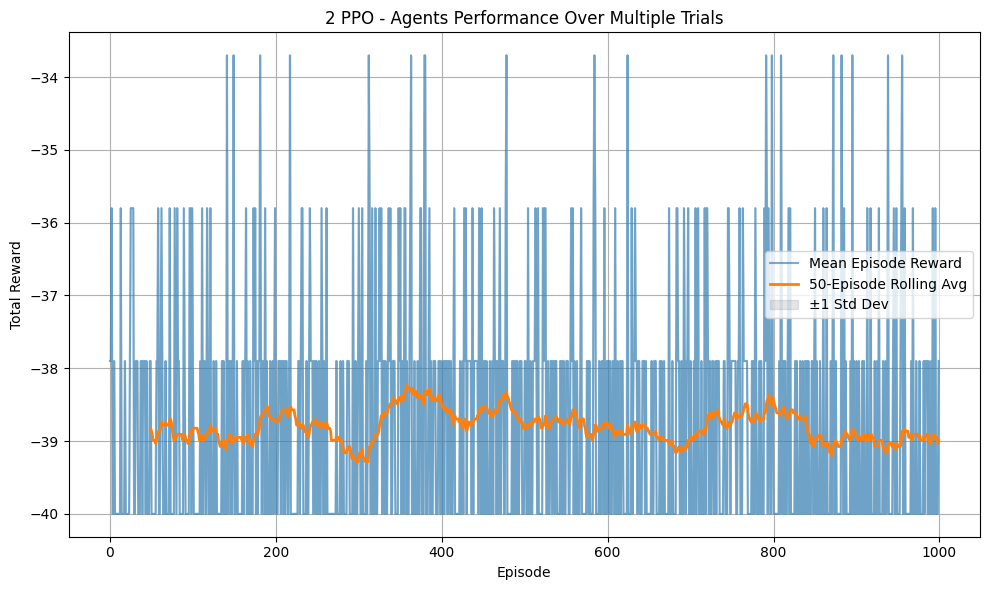

In [ ]:
agent0, agent1, rewards = train_two_ppo_agents(episodes=1000, maxstep=400, layout='small_l', num_trials=1, gamma=0.97, lr=1e-2, eps_clip=0.1, K_epochs=8)
plot_rewards(rewards, window=50, modelname='2 PPO')

Using device: cuda
PPO Trial 1/1: 100%|██████████| 1000/1000 [17:44<00:00,  1.06s/it, Avg Reward=-38.95]


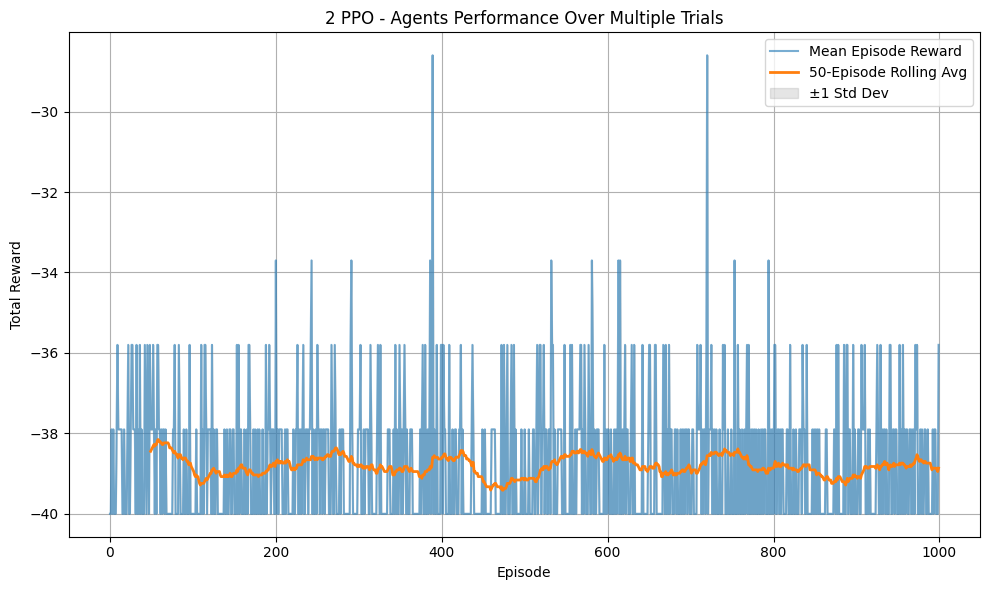

In [ ]:
agent0, agent1, rewards = train_two_ppo_agents(episodes=1000, maxstep=400, layout='small_l', num_trials=1, gamma=0.97, lr=5e-2, eps_clip=0.2, K_epochs=10)
plot_rewards(rewards, window=50, modelname='2 PPO')

Using device: cuda
PPO Trial 1/1: 100%|██████████| 5000/5000 [1:28:24<00:00,  1.06s/it, Avg Reward=-37.27]


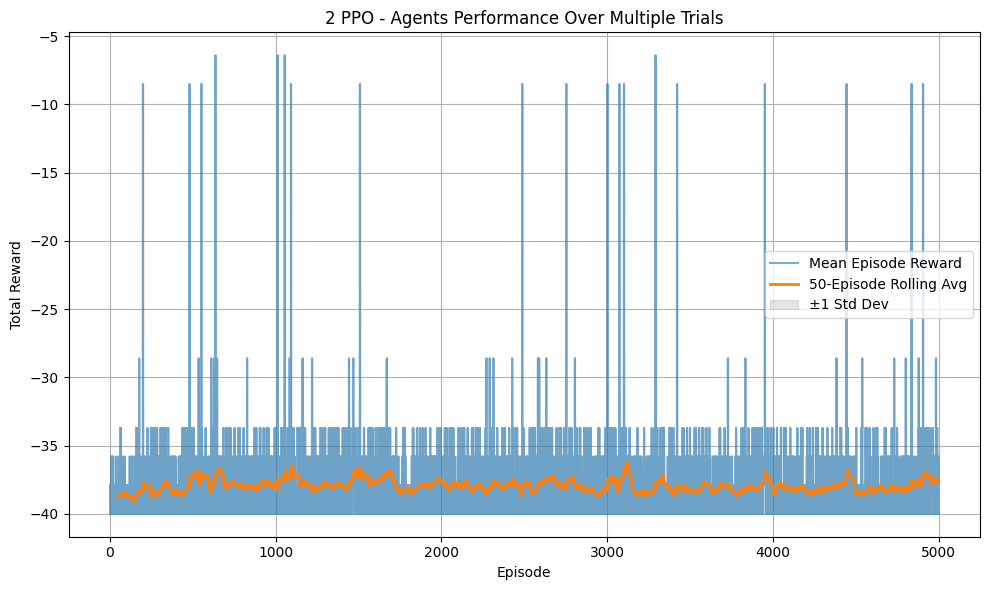

In [ ]:
agent0, agent1, rewards = train_two_ppo_agents(episodes=5000, maxstep=400, layout='small_l', num_trials=1, gamma=0.95, lr=1e-3, eps_clip=0.2, K_epochs=8)
plot_rewards(rewards, window=50, modelname='2 PPO')


## 2 TRPO

In [ ]:
import sys
from tqdm import tqdm

def train_two_trpo_agents(
    layout='small_l',
    episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma = 0.99,
    max_kl = 1e-2,
    cg_iters = 10,
    damping = 1e-2,
    ls_max_steps = 10,
    ls_backtrack_coeff = 0.8, lr = 1e-3, update_epochs = 5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    trial_rewards = []

    for trial in range(num_trials):
        env = Overcooked(layout=layout, max_timesteps=max_steps)
        state_dim = len(env.one_hot_encoding(env.reset()))
        action_dim = env.num_actions

        agent0 = TRPOAgent(state_dim, action_dim, device, gamma,
        max_kl,
        cg_iters,
        damping,
        ls_max_steps,
        ls_backtrack_coeff, lr, update_epochs)

        agent1 = TRPOAgent(state_dim, action_dim, device, gamma,
        max_kl,
        cg_iters,
        damping,
        ls_max_steps,
        ls_backtrack_coeff, lr, update_epochs)

        episode_rewards = []
        progress_bar = tqdm(range(episodes), desc=f"TRPO Trial {trial+1}/{num_trials}", file=sys.stdout)

        for ep in progress_bar:
            state = env.reset()
            buffer0, buffer1 = [], []
            total_reward = 0
            done = False

            while not done:
                state_tensor = torch.FloatTensor(env.one_hot_encoding(state)).to(device)

                a0, logp0, val0 = agent0.select_action(state_tensor)
                a1, logp1, val1 = agent1.select_action(state_tensor)

                joint_action = env.pack_joint_action(a0.item(), a1.item())
                next_state, reward, done, _ = env.step(joint_action)

                buffer0.append((state_tensor, a0, logp0, reward, val0, done))
                buffer1.append((state_tensor, a1, logp1, reward, val1, done))

                state = next_state
                total_reward += reward

            with torch.no_grad():
                final_state_tensor = torch.FloatTensor(env.one_hot_encoding(state)).to(device)
                _, val0_last = agent0.model(final_state_tensor.unsqueeze(0))
                _, val1_last = agent1.model(final_state_tensor.unsqueeze(0))

            agent0.update(buffer0, val0_last.squeeze())
            agent1.update(buffer1, val1_last.squeeze())

            episode_rewards.append(total_reward)
            avg_reward = np.mean(episode_rewards[-10:])
            progress_bar.set_postfix({"Avg Reward": f"{avg_reward:.2f}"})

        trial_rewards.append(episode_rewards)

    return agent0, agent1, np.array(trial_rewards)


Using device: cuda
TRPO Trial 1/1: 100%|██████████| 1000/1000 [18:47<00:00,  1.13s/it, Avg Reward=-40.00]


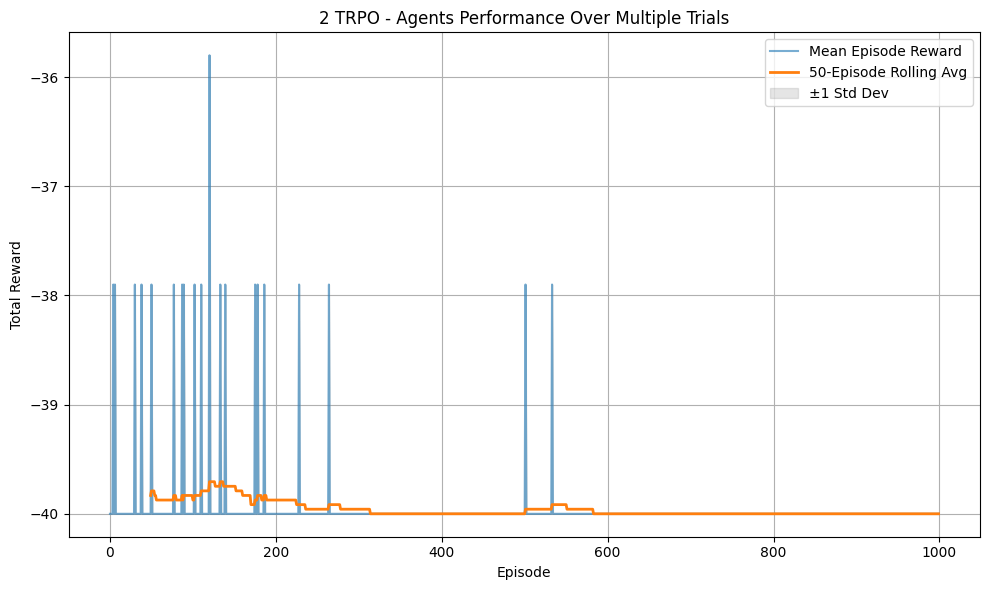

In [ ]:
agent0, agent1, rewards = train_two_trpo_agents(
    layout='small_l',
    episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma = 0.99,
    max_kl = 1e-2,
    cg_iters = 10,
    damping = 1e-2,
    ls_max_steps = 10,
    ls_backtrack_coeff = 0.8, lr = 1e-3, update_epochs = 5
)

plot_rewards(rewards, modelname= '2 TRPO')

Using device: cuda
TRPO Trial 1/1: 100%|██████████| 1000/1000 [19:06<00:00,  1.15s/it, Avg Reward=-39.79]


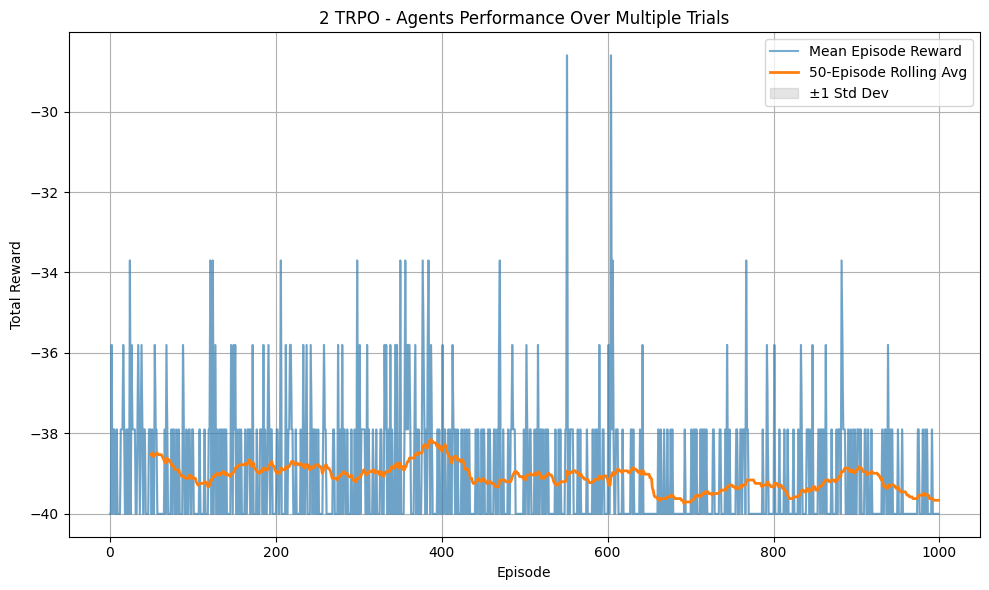

In [ ]:
agent0, agent1, rewards = train_two_trpo_agents(
    layout='small_l',
    episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma = 0.99,
    max_kl = 1e-3,
    cg_iters = 10,
    damping = 1e-2,
    ls_max_steps = 10,
    ls_backtrack_coeff = 0.8, lr = 1e-3, update_epochs = 5
)

plot_rewards(rewards, modelname= '2 TRPO')

Using device: cuda
TRPO Trial 1/1: 100%|██████████| 1000/1000 [20:34<00:00,  1.23s/it, Avg Reward=-40.00]


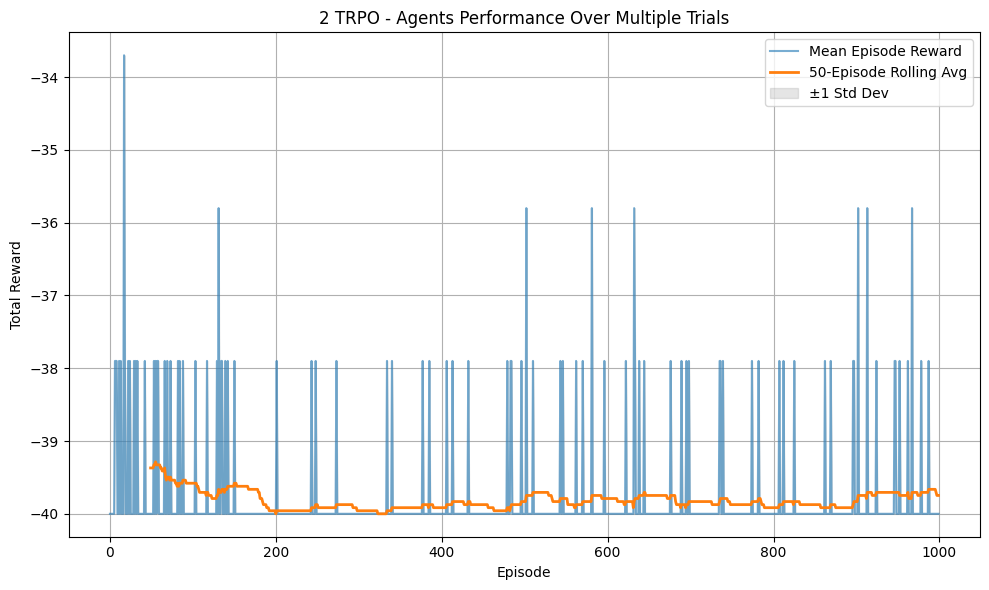

In [ ]:
agent0, agent1, rewards = train_two_trpo_agents(
    layout='small_l',
    episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma = 0.95,
    max_kl = 1e-2,
    cg_iters = 15,
    damping = 1e-2,
    ls_max_steps = 20,
    ls_backtrack_coeff = 0.9, lr = 1e-3, update_epochs = 5
)
plot_rewards(rewards, modelname= '2 TRPO')

Using device: cuda
TRPO Trial 1/1: 100%|██████████| 1000/1000 [19:19<00:00,  1.16s/it, Avg Reward=-37.90]


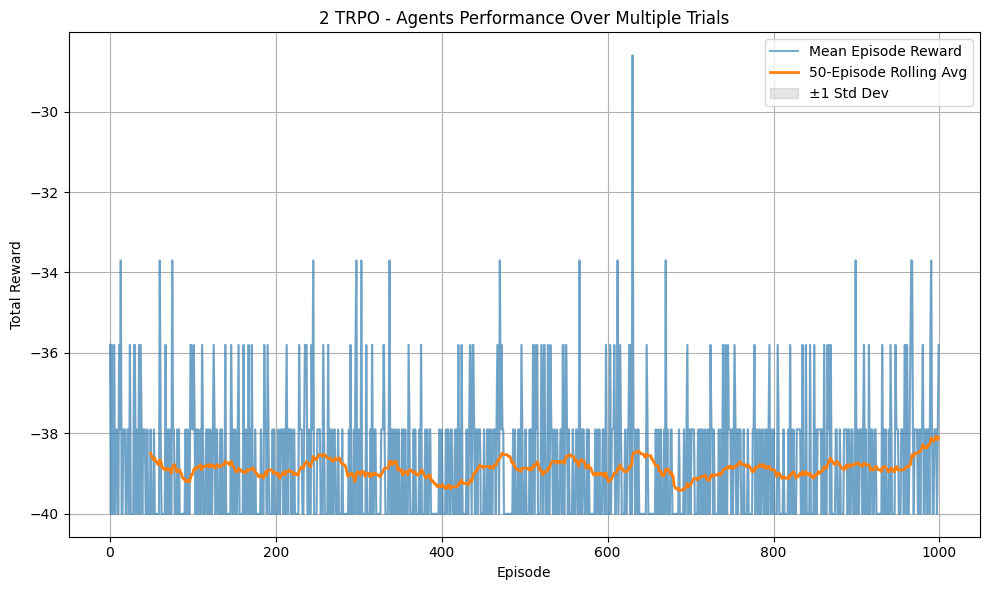

In [ ]:
agent0, agent1, rewards = train_two_trpo_agents(
    layout='small_l',
    episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma = 0.99,
    max_kl = 1e-2,
    cg_iters = 10,
    damping = 1e-2,
    ls_max_steps = 10,
    ls_backtrack_coeff = 0.9, lr = 1e-3, update_epochs = 5
)

plot_rewards(rewards, modelname= '2 TRPO')

Using device: cuda
TRPO Trial 1/1: 100%|██████████| 1000/1000 [18:50<00:00,  1.13s/it, Avg Reward=-39.58]


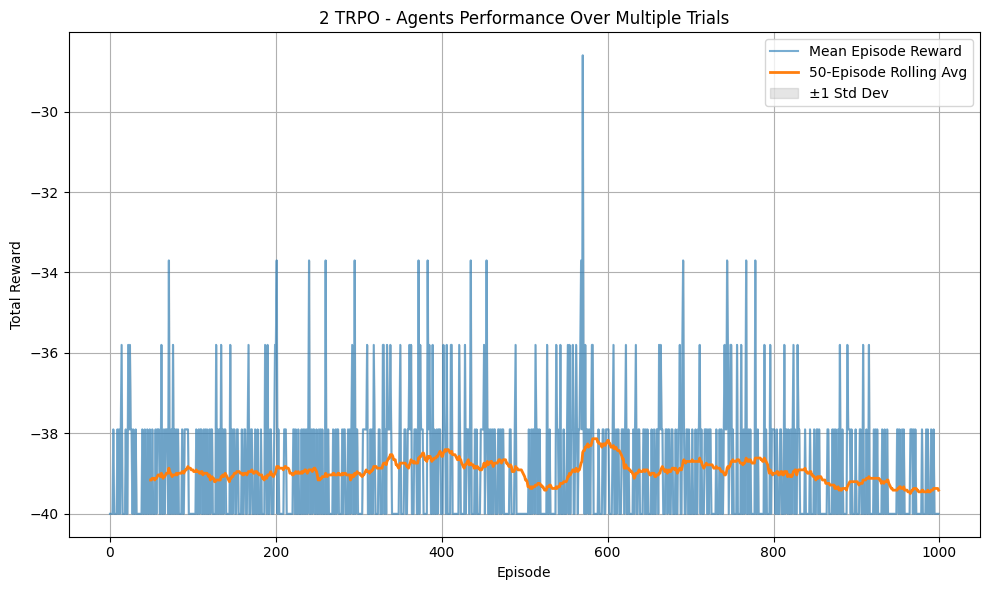

In [ ]:
agent0, agent1, rewards = train_two_trpo_agents(
    layout='small_l',
    episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma = 0.99,
    max_kl = 1e-4,
    cg_iters = 10,
    damping = 1e-2,
    ls_max_steps = 10,
    ls_backtrack_coeff = 0.8, lr = 1e-3, update_epochs = 5
)

plot_rewards(rewards, modelname= '2 TRPO')

Using device: cuda
TRPO Trial 1/1: 100%|██████████| 1000/1000 [18:56<00:00,  1.14s/it, Avg Reward=-38.53]


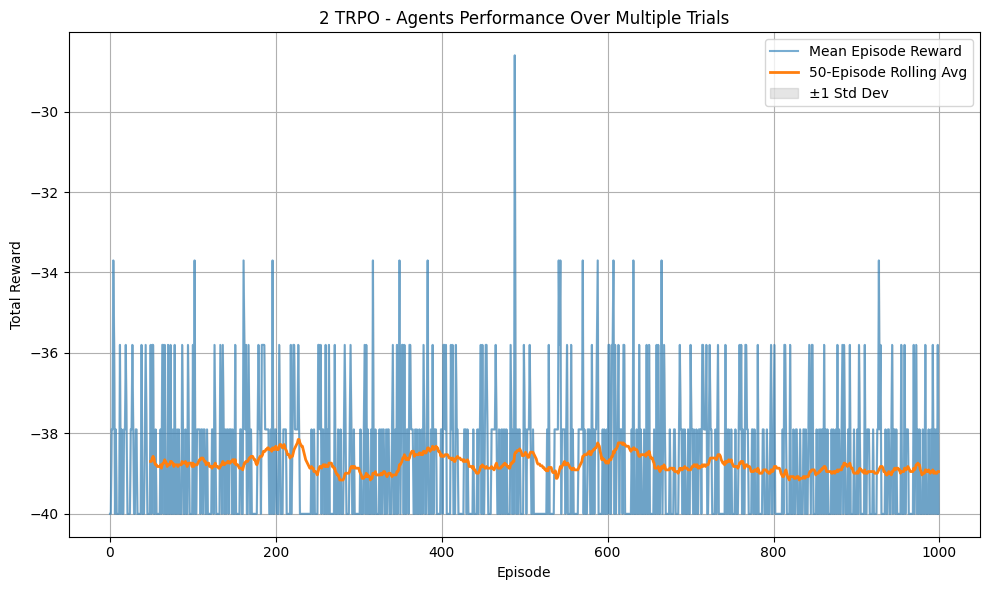

In [ ]:
agent0, agent1, rewards = train_two_trpo_agents(
    layout='small_l',
    episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma = 0.99,
    max_kl = 1e-4,
    cg_iters = 10,
    damping = 1e-3,
    ls_max_steps = 10,
    ls_backtrack_coeff = 0.8, lr = 1e-3, update_epochs = 6
)

plot_rewards(rewards, modelname= '2 TRPO')

Using device: cuda
TRPO Trial 1/1: 100%|██████████| 1000/1000 [20:06<00:00,  1.21s/it, Avg Reward=-40.00]


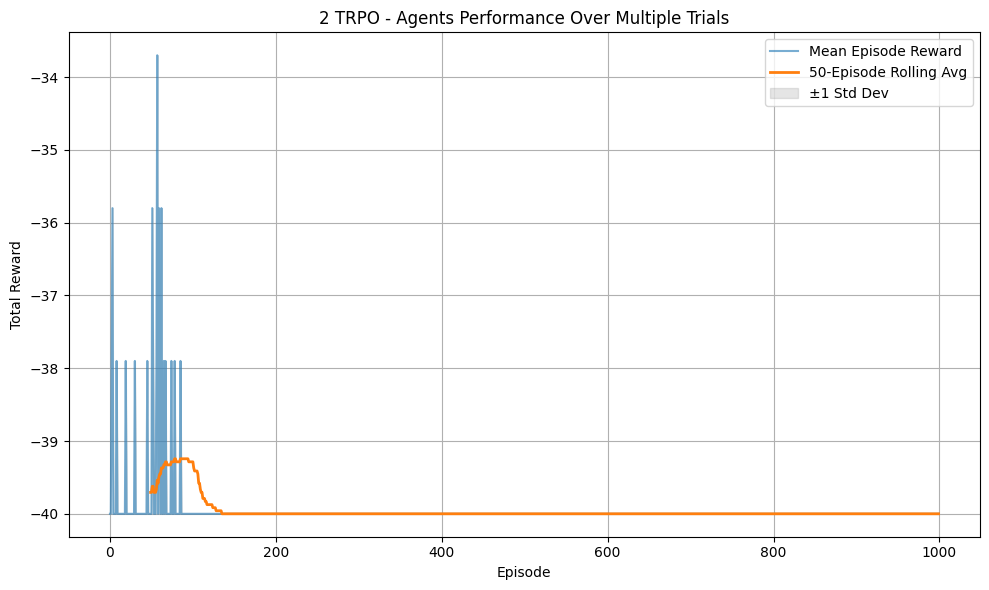

In [ ]:
agent0, agent1, rewards = train_two_trpo_agents(
    layout='small_l',
    episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma = 0.99,
    max_kl = 1e-2,
    cg_iters = 15,
    damping = 1e-2,
    ls_max_steps =15,
    ls_backtrack_coeff = 0.8, lr = 1e-3, update_epochs = 6
)

plot_rewards(rewards, modelname= '2 TRPO')

Using device: cuda
TRPO Trial 1/1: 100%|██████████| 1000/1000 [19:14<00:00,  1.15s/it, Avg Reward=-39.37]


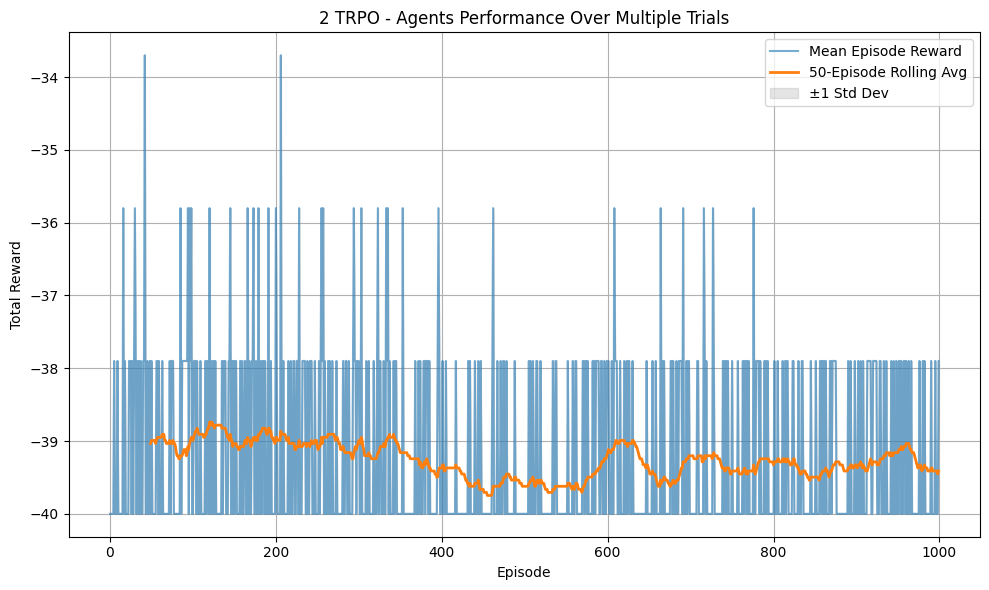

In [ ]:
agent0, agent1, rewards = train_two_trpo_agents(
    layout='small_l',
    episodes=1000,
    num_trials=1,
    max_steps=400,
    gamma = 0.99,
    max_kl = 1e-2,
    cg_iters = 10,
    damping = 1e-2,
    ls_max_steps =10,
    ls_backtrack_coeff = 0.8, lr = 1e-3, update_epochs = 10
)

plot_rewards(rewards, modelname= '2 TRPO')


Using device: cuda
TRPO Trial 1/1: 100%|██████████| 5000/5000 [1:34:12<00:00,  1.13s/it, Avg Reward=-38.53]


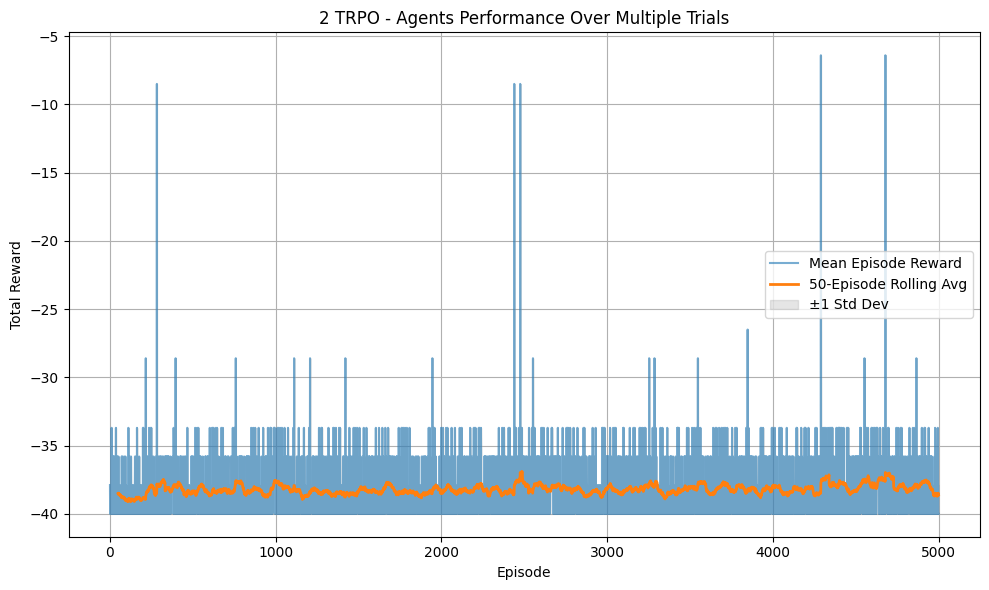

In [ ]:
agent0, agent1, rewards = train_two_trpo_agents(
    layout='small_l',
    episodes=5000,
    num_trials=1,
    max_steps=400,
    gamma = 0.99,
    max_kl = 1e-2,
    cg_iters = 10,
    damping = 1e-2,
    ls_max_steps = 10,
    ls_backtrack_coeff = 0.9, lr = 1e-3, update_epochs = 5
)

plot_rewards(rewards, modelname= '2 TRPO')

## end
